# myAOAnet

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from os.path import join
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, accuracy_score
%matplotlib inline

## IQ data visualization

In [30]:
data_from = 'data_1606'

In [31]:
iq_data0 = pd.read_csv(join(data_from, 'iq_example', 'log_long.csv'), sep=',', header=0)

KeyboardInterrupt: 

In [ ]:
iq_data = iq_data0.drop(iq_data0.columns[[index for index in range(11)]], axis = 1, inplace = False)
iq_data.shape

In [ ]:
iq_data[abs(iq_data['field.data2']) >= 5e-4]

In [137]:
sample_id = 4
iq_data_np = iq_data.to_numpy()[sample_id, :]

In [138]:
iq_arr = iq_data_np.reshape(4, 32768, 2)

Text(0.5, 1.0, 'Imag part of IQ CHN=3')

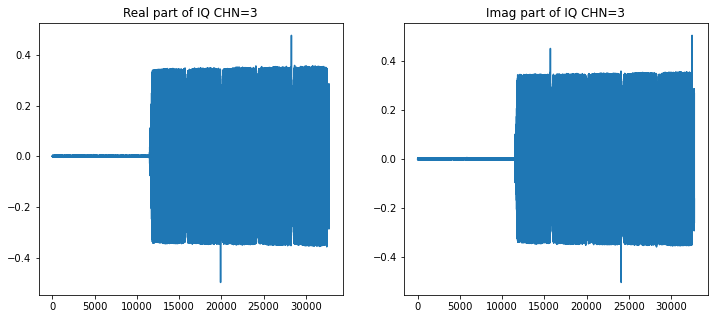

In [143]:
chn = 3

fig0 ,ax0 = plt.subplots(1, 2,figsize=(12,5))
ax0[0].plot(iq_arr[chn, :, 0])
ax0[0].set_title("Real part of IQ CHN=%d" % chn)
ax0[1].plot(iq_arr[chn, :, 1])
ax0[1].set_title("Imag part of IQ CHN=%d" % chn)
#plt.show()

In [144]:
iq_amp = np.zeros((32768, 4))
iq_amp = np.sqrt(iq_arr[:, :, 0]**2 + iq_arr[:, :, 1]**2)
iq_amp.shape

(4, 32768)

In [145]:
iq_phase2 = np.zeros((32768, 4))
iq_phase2 = np.angle(iq_arr[:, :, 0] + iq_arr[:, :, 1]*1j)
iq_phase2.shape

(4, 32768)

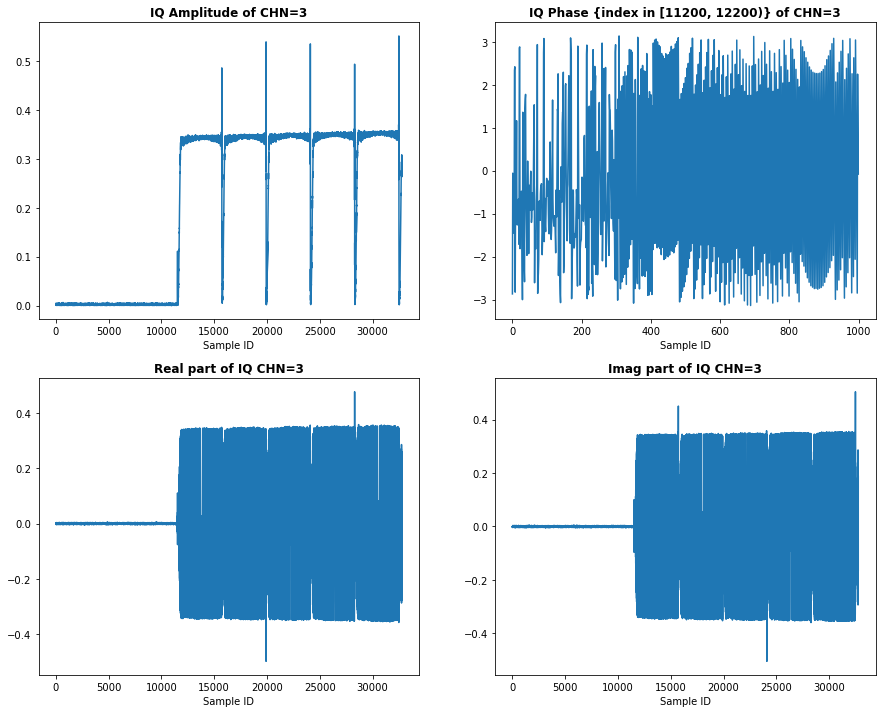

In [155]:
fig ,ax = plt.subplots(2, 2,figsize=(15,12))
ax[0,0].plot(iq_amp[chn, :])
ax[0,0].set_title("IQ Amplitude of CHN=%d" % chn, fontweight='bold')
ax[0,0].set_xlabel("Sample ID")
ax[0,1].plot(iq_phase2[chn, 11200:12200])
ax[0,1].set_title("IQ Phase {index in [11200, 12200)} of CHN=%d" % chn, fontweight='bold')
ax[0,1].set_xlabel("Sample ID")

ax[1,0].plot(iq_arr[chn, :, 0])
ax[1,0].set_title("Real part of IQ CHN=%d" % chn, fontweight='bold')
ax[1,0].set_xlabel("Sample ID")
ax[1,1].plot(iq_arr[chn, :, 1])
ax[1,1].set_title("Imag part of IQ CHN=%d" % chn, fontweight='bold')
ax[1,1].set_xlabel("Sample ID")

plt.show()

In [156]:
fig.savefig(join('doc', '{data_from}-{samp_id}-{chn}'.format(data_from=data_from, samp_id=sample_id, chn=chn)), \
           facecolor="w", bbox_inches='tight')

## Load Raw Data and Save Signal_index & Music series

In [255]:
### Prepare Data from (ROSBAG ->) CSV -> DataFrame ###
def load_raw(data_dir='testLOS', field_thres=1e-5, measure_music=False):
    aoa_dict = {}

    for filename in os.listdir(data_dir):
        if filename.startswith("deg_m") and filename.endswith(".csv"):
            aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[- int(filename[5:-4])] = aoa_Rjk
        elif filename.startswith("deg_") and filename.endswith(".csv"):
            aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[int(filename[4:-4])] = aoa_Rjk

    # Degree to Radian
    for key in aoa_dict.keys():
        aoa_dict[key]['theta'] = key * math.pi / 180

    # Differentiate R from LoRa signal to Noise
    aoa_sig, aoa_noi = {}, {}
    sig_index_lst = {}

    # Filtering noise based on the threshold
    for key in aoa_dict.keys():
        filtered_indexed = aoa_dict[key][(abs(aoa_dict[key]['field.data2']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data3']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data4']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data5']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data6']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data7']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data12']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data13']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data14']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data15']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data22']) >= field_thres) \
                                         & (abs(aoa_dict[key]['field.data23']) >= field_thres)].index
        
        aoa_sig[key] = aoa_dict[key].iloc[filtered_indexed]
        aoa_noi[key] = aoa_dict[key].drop(filtered_indexed)
        sig_index_lst[key] = (filtered_indexed)

    # Concat dict of raw data into a DataFrame
    X = pd.concat([aoa_sig[rad] for rad in aoa_sig.keys()],
                  keys=[rad for rad in aoa_sig.keys()], names=['Series name', 'Row ID'])

    # Add a Column of MUSIC measurement; if no measurement, add 'NaN'
    if measure_music:
        music_dict = {}
        for filename in os.listdir(data_dir):
            if filename.startswith("music_deg_m") and filename.endswith(".csv"):
                music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
                music_deg.rename(columns={'field.data': 'music'}, inplace=True)
                music_series = music_deg['music']
                music_dict[- int(filename[11:-4])] = music_series
            elif filename.startswith("music_deg_") and filename.endswith(".csv"):
                music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
                music_deg.rename(columns={'field.data': 'music'}, inplace=True)
                music_series = music_deg['music']
                music_dict[int(filename[10:-4])] = music_series

        for key in music_dict.keys():
            music_dict[key] = music_dict[key][sig_index_lst[key]]

        Xmusic = pd.concat([music_dict[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)],
                           names=['Series name', 'Row ID'])
        X = pd.concat([X, Xmusic], axis=1)

    else:
        Xmusic = pd.Series([0] * len(X.index))
        X = pd.concat([X, Xmusic], axis=1)

    return X, Xmusic, sig_index_lst

In [ ]:
# Process All
for work_dir in ['data_1606', 'data_0107', 'data_0207', 'data_1407', 'data_1607']:
    df, df_music, df_sig_index = load_raw(data_dir=work_dir, measure_music=True)
    # Saving
    df_music.to_csv(join(work_dir, 'df_collection', 'music_series.csv'), index=True, header=True)
    with open(join(work_dir, 'df_collection', 'sig_index.pkl'), "wb") as a_file:
        pickle.dump(df_sig_index, a_file)
    print(df)

In [256]:
df, df_music, df_sig_index = load_raw(data_dir='data_1607', measure_music=True)

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [257]:
df.equals(X_1607[0])

False

## R-AOA Dataframe

In [196]:
data_dir = 'data_1607'
aoa_dict = {}
#fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data5', 'field.data6', 'field.data7', 'field.data10', 'field.data11', 'field.data15']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']

for filename in os.listdir(data_dir):
    if filename.startswith("deg_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[- float(filename[5:-4])] = aoa_Rjk
    elif filename.startswith("deg_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[float(filename[4:-4])] = aoa_Rjk

In [197]:
num_fields = aoa_dict[0].shape[1]
aoa_dict[70].iloc[:55]

,field.data0,field.data1,field.data2,field.data3,field.data4,field.data5,field.data6,field.data7,field.data10,field.data11,field.data12,field.data13,field.data14,field.data15,field.data20,field.data21,field.data22,field.data23,field.data30,field.data31
0,4.071116e-08,0.0,-3.580400e-10,-1.578591e-09,-3.854807e-08,1.418575e-08,-3.882046e-08,-1.671271e-08,0.000004,0.0,-1.860933e-08,1.323781e-08,-4.890665e-10,-5.028167e-10,0.000006,0.0,4.764514e-07,4.308334e-07,0.000004,0.0
1,4.101046e-08,0.0,-3.552547e-09,1.572898e-09,-4.565996e-08,1.181183e-08,-3.892773e-08,-1.902254e-08,0.000004,0.0,-3.300906e-08,6.826778e-09,9.203653e-09,2.349956e-08,0.000006,0.0,4.373682e-07,3.673061e-07,0.000004,0.0
2,5.947249e-05,0.0,-6.767028e-04,-1.038397e-03,-4.658764e-04,-7.013131e-04,-6.817633e-05,7.651789e-04,0.025855,0.0,1.754557e-02,-1.451844e-04,-1.259538e-02,-9.903544e-03,0.012012,0.0,-8.489106e-03,-6.789570e-03,0.009936,0.0
3,6.785875e-05,0.0,-7.892320e-04,-1.079313e-03,-5.857407e-04,-7.041986e-04,-9.697910e-05,8.516760e-04,0.026414,0.0,1.805897e-02,-1.095980e-03,-1.243594e-02,-1.144472e-02,0.012518,0.0,-8.004382e-03,-8.334195e-03,0.010844,0.0
4,8.655286e-05,0.0,-9.276284e-04,-1.063017e-03,-7.860859e-04,-5.669974e-04,-1.585968e-04,1.032264e-03,0.023127,0.0,1.548896e-02,-3.537411e-03,-1.100140e-02,-1.302203e-02,0.011040,0.0,-5.338152e-03,-1.040289e-02,0.012617,0.0
5,1.206358e-04,0.0,-9.418277e-04,-1.299851e-03,-8.166363e-04,-5.085113e-04,-2.436812e-04,1.422951e-03,0.021458,0.0,1.192738e-02,-4.795440e-03,-1.344230e-02,-1.374105e-02,0.007803,0.0,-4.352660e-03,-1.064774e-02,0.017291,0.0
6,1.359641e-04,0.0,-7.668511e-04,-1.534785e-03,-6.208704e-04,-5.552272e-04,-2.868198e-04,1.622761e-03,0.021708,0.0,9.801029e-03,-3.860490e-03,-1.671081e-02,-1.239431e-02,0.005172,0.0,-5.316942e-03,-8.571073e-03,0.019987,0.0
7,1.347288e-04,0.0,-6.395553e-04,-1.684392e-03,-4.272377e-04,-6.838623e-04,-2.536440e-04,1.635690e-03,0.024129,0.0,1.059541e-02,-2.080407e-03,-1.925633e-02,-1.093315e-02,0.004891,0.0,-7.492594e-03,-6.458250e-03,0.020352,0.0
8,1.247744e-04,0.0,-5.556482e-04,-1.718690e-03,-2.926526e-04,-7.850478e-04,-1.992354e-04,1.551669e-03,0.026176,0.0,1.212491e-02,-5.223872e-04,-2.049875e-02,-9.654073e-03,0.005688,0.0,-9.290739e-03,-4.879070e-03,0.019631,0.0
9,1.235308e-04,0.0,-4.998680e-04,-1.765546e-03,-2.121625e-04,-8.361111e-04,-1.821000e-04,1.540237e-03,0.027282,0.0,1.281072e-02,3.573913e-04,-2.128826e-02,-8.840123e-03,0.006077,0.0,-1.010692e-02,-3.872384e-03,0.019487,0.0


In [198]:
raw_data_len = [aoa_dict[deg].shape[0] for deg in aoa_dict.keys()]
sum(raw_data_len)

8215

(1) Update R filtering threshold

In [199]:
#Degree to Radian
for key in aoa_dict.keys():
    aoa_dict[key]['theta'] = key * math.pi / 180

# Show detection of LoRa beacon when Rjk is significant
field_thres = 1e-05

# List of data.fields used in filtering
fields_filter_lst = ['field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data22', 'field.data23']

for key in aoa_dict.keys():
    print("%s shape of signal-presenting snapshots = %.01f" % (str(aoa_dict[key][(abs(aoa_dict[key]['field.data2']) >= field_thres) \
                                                                                 & (abs(aoa_dict[key]['field.data3']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data4']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data5']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data6']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data7']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data12']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data13']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data14']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data15']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data22']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data23']) >= field_thres)].shape), key))

(152, 21) shape of signal-presenting snapshots = 0.0
(132, 21) shape of signal-presenting snapshots = 60.0
(147, 21) shape of signal-presenting snapshots = -50.0
(107, 21) shape of signal-presenting snapshots = -60.0
(149, 21) shape of signal-presenting snapshots = -40.0
(149, 21) shape of signal-presenting snapshots = 20.0
(156, 21) shape of signal-presenting snapshots = 70.0
(152, 21) shape of signal-presenting snapshots = 40.0
(155, 21) shape of signal-presenting snapshots = 30.0
(101, 21) shape of signal-presenting snapshots = -30.0
(134, 21) shape of signal-presenting snapshots = -70.0
(153, 21) shape of signal-presenting snapshots = -20.0
(156, 21) shape of signal-presenting snapshots = 10.0
(184, 21) shape of signal-presenting snapshots = -10.0
(158, 21) shape of signal-presenting snapshots = 50.0


/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [200]:
# Differentiate R of LoRa signal or noise
aoa_sig, aoa_noi = {}, {}
sig_index_lst = {}

for key in aoa_dict.keys():
    filtered_indexed = aoa_dict[key][(abs(aoa_dict[key]['field.data2']) >= field_thres) \
                                                                                 & (abs(aoa_dict[key]['field.data3']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data4']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data5']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data6']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data7']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data12']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data13']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data14']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data15']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data22']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data23']) >= field_thres)].index
    
    aoa_sig[key] = aoa_dict[key].iloc[filtered_indexed]
    aoa_noi[key] = aoa_dict[key].drop(filtered_indexed)
    
    sig_index_lst[key] = (filtered_indexed)
    
sig_index_lst[-10]

Int64Index([ 15,  16,  17,  18,  19,  21,  22,  24,  25,  50,
            ...
            580, 581, 607, 608, 609, 610, 611, 613, 614, 615],
           dtype='int64', length=184)

In [201]:
# Save sig_index!
import pickle

with open(join(data_dir, 'df_collection', 'sig_index.pkl'), "wb") as a_file:
    pickle.dump(sig_index_lst, a_file)

In [202]:
# Load sig index
'''
#data_dir = 'data_1606'
import pickle

with open(join(data_dir, 'df_collection', 'sig_index.pkl'), "rb") as a_file:
    sig_index_lst = pickle.load(a_file)
'''

'\n#data_dir = \'data_1606\'\nimport pickle\n\nwith open(join(data_dir, \'df_collection\', \'sig_index.pkl\'), "rb") as a_file:\n    sig_index_lst = pickle.load(a_file)\n'

In [203]:
# Xaoa = aoa_sig <-> theta[Rad]
Xaoa = pd.concat([aoa_sig[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
idx = pd.IndexSlice

In [204]:
print(Xaoa.shape)
Xaoa.loc[idx[[-10, 0, 30, 70], :], :]
Xaoa

(2185, 21)


field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         1          0.000097          0.0     0.000327     0.000842   
            3          0.000079          0.0    -0.000209     0.000807   
            4          0.000051          0.0    -0.000268     0.000665   
            5          0.000034          0.0    -0.000192     0.000579   
            6          0.000026          0.0    -0.000114     0.000533   
...                         ...          ...          ...          ...   
 70         494        0.000065          0.0    -0.000850    -0.001009   
            495        0.000065          0.0    -0.000860    -0.001015   
            496        0.000065          0.0    -0.000864    -0.001002   
            497        0.000064          0.0    -0.000859    -0.000990   
            498        0.000043          0.0    -0.000582    -0.000666   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         1         -0.001752     0.000655    -0.000492    -0.001703   
            3         -0.001915    -0.000089     0.000171    -0.001603   
            4         -0.001531    -0.000128     0.000253    -0.001188   
            5         -0.001236    -0.000026     0.000152    -0.000951   
            6         -0.001058     0.000089     0.000047    -0.000811   
...                         ...          ...          ...          ...   
 70         494       -0.000507    -0.000725     0.000058     0.000724   
            495       -0.000508    -0.000731     0.000059     0.000731   
            496       -0.000515    -0.000720     0.000063     0.000726   
            497       -0.000514    -0.000714     0.000062     0.000718   
            498       -0.000344    -0.000483     0.000045     0.000484   

                    field.data10  field.data11  ...  field.data13  \
Series name Row ID                              ...                 
-70         1           0.008564           0.0  ...      0.017663   
            3           0.008913           0.0  ...      0.019981   
            4           0.010230           0.0  ...      0.020890   
            5           0.011085           0.0  ...      0.021410   
            6           0.011567           0.0  ...      0.021558   
...                          ...           ...  ...           ...   
 70         494         0.026824           0.0  ...      0.001612   
            495         0.027087           0.0  ...      0.001739   
            496         0.026922           0.0  ...      0.001645   
            497         0.026717           0.0  ...      0.001625   
            498         0.018094           0.0  ...      0.001209   

                    field.data14  field.data15  field.data20  field.data21  \
Series name Row ID                                                           
-70         1          -0.016640     -0.001444      0.036835           0.0   
            3          -0.016972      0.002511      0.047196           0.0   
            4          -0.017037      0.002971      0.047190           0.0   
            5          -0.017246      0.002826      0.045667           0.0   
            6          -0.017027      0.002631      0.044281           0.0   
...                          ...           ...           ...           ...   
 70         494        -0.012031     -0.008578      0.012133           0.0   
            495        -0.012130     -0.008695      0.012194           0.0   
            496        -0.012025     -0.008666      0.012127           0.0   
            497        -0.011885     -0.008628      0.012112           0.0   
            498        -0.008057     -0.005822      0.008178           0.0   

                    field.data22  field.data23  field.data30  field.data31  \
Series name Row ID                                                           
-70         1          -0

In [205]:
# Save raw X
Xaoa.to_csv(join(data_dir, 'df_collection', 'Xraw.csv'), index=True, header=True)

### MUSIC

In [206]:
# Notice Noisy Rosbags do not contain 'kerberos/doa_results'
#data_dir = 'data_0107'
music_dict = {}

for filename in os.listdir(data_dir):
    if filename.startswith("music_deg_m") and filename.endswith(".csv"):
        music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        music_deg.rename(columns = {'field.data': 'music'}, inplace=True)
        music_series = music_deg['music']
        music_dict[- float(filename[11:-4])] = music_series
    elif filename.startswith("music_deg_") and filename.endswith(".csv"):
        music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        music_deg.rename(columns = {'field.data': 'music'}, inplace=True)
        music_series = music_deg['music']
        music_dict[float(filename[10:-4])] = music_series

In [207]:
for key in music_dict.keys():
    music_dict[key] = music_dict[key][sig_index_lst[key]]

In [208]:
# Add MUSIC_results as 22nd column
Xmusic = pd.concat([music_dict[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
Xaoa_music = pd.concat([Xaoa, Xmusic], axis=1)
Xaoa_music

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         1          0.000097          0.0     0.000327     0.000842   
            3          0.000079          0.0    -0.000209     0.000807   
            4          0.000051          0.0    -0.000268     0.000665   
            5          0.000034          0.0    -0.000192     0.000579   
            6          0.000026          0.0    -0.000114     0.000533   
...                         ...          ...          ...          ...   
 70         494        0.000065          0.0    -0.000850    -0.001009   
            495        0.000065          0.0    -0.000860    -0.001015   
            496        0.000065          0.0    -0.000864    -0.001002   
            497        0.000064          0.0    -0.000859    -0.000990   
            498        0.000043          0.0    -0.000582    -0.000666   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         1         -0.001752     0.000655    -0.000492    -0.001703   
            3         -0.001915    -0.000089     0.000171    -0.001603   
            4         -0.001531    -0.000128     0.000253    -0.001188   
            5         -0.001236    -0.000026     0.000152    -0.000951   
            6         -0.001058     0.000089     0.000047    -0.000811   
...                         ...          ...          ...          ...   
 70         494       -0.000507    -0.000725     0.000058     0.000724   
            495       -0.000508    -0.000731     0.000059     0.000731   
            496       -0.000515    -0.000720     0.000063     0.000726   
            497       -0.000514    -0.000714     0.000062     0.000718   
            498       -0.000344    -0.000483     0.000045     0.000484   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-70         1           0.008564           0.0  ...     -0.016640   
            3           0.008913           0.0  ...     -0.016972   
            4           0.010230           0.0  ...     -0.017037   
            5           0.011085           0.0  ...     -0.017246   
            6           0.011567           0.0  ...     -0.017027   
...                          ...           ...  ...           ...   
 70         494         0.026824           0.0  ...     -0.012031   
            495         0.027087           0.0  ...     -0.012130   
            496         0.026922           0.0  ...     -0.012025   
            497         0.026717           0.0  ...     -0.011885   
            498         0.018094           0.0  ...     -0.008057   

                    field.data15  field.data20  field.data21  field.data22  \
Series name Row ID                                                           
-70         1          -0.001444      0.036835           0.0     -0.002675   
            3           0.002511      0.047196           0.0     -0.002380   
            4           0.002971      0.047190           0.0     -0.004697   
            5           0.002826      0.045667           0.0     -0.004809   
            6           0.002631      0.044281           0.0     -0.004733   
...                          ...           ...           ...           ...   
 70         494        -0.008578      0.012133           0.0     -0.008535   
            495        -0.008695      0.012194           0.0     -0.008624   
            496        -0.008666      0.012127           0.0     -0.008530   
            497        -0.008628      0.012112           0.0     -0.008457   
            498        -0.005822      0.008178           0.0     -0.005754   

                    field.data23  field.data30  field.data31    theta  music  
Series name Row ID                                                            
-70         1          

In [209]:
print(data_dir)
Xmusic.to_csv(join(data_dir, 'df_collection', 'music_series.csv'), index=True, header=True)

data_1607


In [210]:
Xaoa_music.to_csv(join(data_dir, 'df_collection', 'Xaoa_music.csv'), index=True, header=True)

## Create Origin-Noisy-MUSIC dataset
### Start from here: if Data have been preprocessed

In [11]:
#field_thres = 1e-05
#fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data5', 'field.data6', 'field.data7', 'field.data10', 'field.data11', 'field.data15']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']

def create_dataset(dirname, sigma, Xmusic, sig_index_lst, fields_lst=fields_lst):
    aoa_dict = {}

    for filename in os.listdir(dirname):
        #print(join(dirname, filename))
        if filename.startswith("deg_m") and filename.endswith("_" + sigma + ".csv"):
            aoa = pd.read_csv(join(dirname, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[- float(filename[5:-9])] = aoa_Rjk
        elif filename.startswith("deg_") and filename.endswith("_" + sigma + ".csv"):
            aoa = pd.read_csv(join(dirname, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[float(filename[4:-9])] = aoa_Rjk
    
    aoa_sig, aoa_noi = {}, {}
    #sig_index_lst = {}
            
    for key in aoa_dict.keys():
        aoa_dict[key]['theta'] = key * math.pi / 180
        #print(key ,aoa_dict[key].shape)
        #print(sig_index_lst[key])
        
        # Patch: cut positional idx that are out-of-bound
        #slice_idx = sig_index_lst[key]
        #slice_idx = slice_idx[slice_idx<len(sig_index_lst[key])]
        try:
            aoa_sig[key] = aoa_dict[key].iloc[sig_index_lst[key], :]
        except IndexError:
            aoa_sig[key] = aoa_dict[key].iloc[sig_index_lst[key][:-3], :]
    
    Xaoa_noi = pd.concat([aoa_sig[rad] for rad in range(-70, 80, 10)], \
                     keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
    
    Xaoa_noi_music = pd.concat([Xaoa_noi, Xmusic], axis=1)
    return Xaoa_noi_music
    

In [3]:
# trick: slice pd.Int64Index
#sig_index_lst[10][:-1]

In [4]:
import pickle

#Noi_dir_lst = ['noisy1', 'noisy2', 'noisy3', 'noisy4', 'noisy5']
#Sigmas = ['1e_5', '5e_5', '1e_4', '5e_4']

#Noi_dir_lst = ['noisy10', 'noisy11', 'noisy12', 'noisy13', 'noisy14']
#Sigmas = ['1e_3', '2e_3', '3e_3', '4e_3', '5e_3']

Noi_dir_lst = ['noisy1', 'noisy2', 'noisy3', 'noisy4', 'noisy5', 'noisy10', 'noisy11', 'noisy12', 'noisy13', 'noisy14']
Sigmas = ['5e_5', '1e_4', '5e_4', '1e_3', '2e_3']

def get_X_list(dirname, noi_dir_lst=Noi_dir_lst, sigmas=Sigmas):
    Xaoa_music = pd.read_csv(join(dirname, 'df_collection', 'Xaoa_music.csv'), index_col=[0, 1])
    Xnoisy_parts = [Xaoa_music]
    with open(join(dirname, 'df_collection', 'sig_index.pkl'), "rb") as a_file:
        sig_index_lst = pickle.load(a_file)
        
    Xmusic = pd.read_csv(join(dirname, 'df_collection', 'music_series.csv'), index_col=[0, 1])
    
    for noi_dir in noi_dir_lst:
        noisy_dir = join(dirname, noi_dir)
        
        for sigma in sigmas:
            # only process noisy data in Noi_dir_lst & Sigmas
            for file in os.listdir(noisy_dir):
                if file.startswith("deg_") and file.endswith("_" + sigma + ".csv"):
                    Xnoisy_parts.append(create_dataset(noisy_dir, sigma, Xmusic, sig_index_lst))
                    break
        
    return Xnoisy_parts

X_1607 = get_X_list('data_1607')  # NLOS interior-to-outdoor
X_1407 = get_X_list('data_1407')  # LOS open with reflector
#'''
X_0207 = get_X_list('data_0207')  # NLOS corridor
X_0107 = get_X_list('data_0107')  # NLOS office
X_1606 = get_X_list('data_1606')  # LOS open area
#'''

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [5]:
X =  X_1606 + X_0207 + X_0107 + X_1407 + X_1607
X1 = X_1606
#X1 = Xaoa_music

print(len(X))
X[0].shape

130


(3360, 22)

In [6]:
X[28]

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         2          0.000069          0.0    -0.000096     0.000401   
            3          0.000082          0.0    -0.000124     0.000550   
            4          0.000083          0.0    -0.000205     0.000557   
            5          0.000102          0.0    -0.000233     0.000545   
            6          0.000119          0.0    -0.000146     0.000618   
...                         ...          ...          ...          ...   
 70         676        0.000441          0.0     0.000356    -0.003052   
            677        0.000417          0.0     0.000344    -0.002973   
            678        0.000410          0.0     0.000343    -0.002986   
            679        0.000397          0.0     0.000269    -0.002909   
            680        0.000061          0.0     0.000046    -0.000448   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         2         -0.000033     0.000110     0.003592    -0.001316   
            3         -0.000055     0.000155     0.004418    -0.001806   
            4         -0.000179     0.000188     0.004404    -0.001644   
            5         -0.000221     0.000108     0.004948    -0.001760   
            6         -0.000089     0.000093     0.005472    -0.002195   
...                         ...          ...          ...          ...   
 70         676        0.001992    -0.009967    -0.005236    -0.010559   
            677        0.001850    -0.009749    -0.005144    -0.010113   
            678        0.001788    -0.009802    -0.005243    -0.010035   
            679        0.001625    -0.009655    -0.005122    -0.009825   
            680        0.000260    -0.001490    -0.000821    -0.001501   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-70         2           0.002485           0.0  ...     -0.012608   
            3           0.003932           0.0  ...     -0.018829   
            4           0.004274           0.0  ...     -0.021845   
            5           0.003482           0.0  ...     -0.020603   
            6           0.003433           0.0  ...     -0.018094   
...                          ...           ...  ...           ...   
 70         676         0.021526           0.0  ...      0.068467   
            677         0.021580           0.0  ...      0.067422   
            678         0.022114           0.0  ...      0.068217   
            679         0.021587           0.0  ...      0.068055   
            680         0.003349           0.0  ...      0.010342   

                    field.data15  field.data20  field.data21  field.data22  \
Series name Row ID                                                           
-70         2          -0.018938      0.000200           0.0     -0.003816   
            3          -0.026863      0.000338           0.0     -0.006333   
            4          -0.025350      0.000828           0.0     -0.013175   
            5          -0.022250      0.000615           0.0     -0.012496   
            6          -0.025658      0.000174           0.0     -0.005786   
...                          ...           ...           ...           ...   
 70         676        -0.044522      0.235177           0.0      0.213958   
            677        -0.044754      0.236816           0.0      0.212456   
            678        -0.046269      0.242704           0.0      0.215742   
            679        -0.043886      0.241972           0.0      0.216630   
            680        -0.007117      0.037724           0.0      0.033009   

                    field.data23  field.data30  field.data31    theta  music  
Series name Row ID                                                            
-70         2          

In [7]:
X[27]

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         2          0.000069          0.0    -0.000096     0.000401   
            3          0.000082          0.0    -0.000124     0.000551   
            4          0.000083          0.0    -0.000205     0.000557   
            5          0.000102          0.0    -0.000233     0.000545   
            6          0.000119          0.0    -0.000146     0.000618   
...                         ...          ...          ...          ...   
 70         676        0.000441          0.0     0.000355    -0.003052   
            677        0.000417          0.0     0.000344    -0.002973   
            678        0.000410          0.0     0.000343    -0.002985   
            679        0.000397          0.0     0.000269    -0.002909   
            680        0.000061          0.0     0.000046    -0.000448   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         2         -0.000033     0.000110     0.003592    -0.001317   
            3         -0.000055     0.000155     0.004418    -0.001806   
            4         -0.000179     0.000188     0.004403    -0.001644   
            5         -0.000221     0.000108     0.004948    -0.001759   
            6         -0.000089     0.000093     0.005473    -0.002195   
...                         ...          ...          ...          ...   
 70         676        0.001992    -0.009967    -0.005236    -0.010559   
            677        0.001850    -0.009749    -0.005144    -0.010113   
            678        0.001788    -0.009802    -0.005243    -0.010034   
            679        0.001625    -0.009655    -0.005122    -0.009824   
            680        0.000260    -0.001490    -0.000821    -0.001501   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-70         2           0.002485           0.0  ...     -0.012608   
            3           0.003932           0.0  ...     -0.018830   
            4           0.004274           0.0  ...     -0.021845   
            5           0.003482           0.0  ...     -0.020603   
            6           0.003433           0.0  ...     -0.018094   
...                          ...           ...  ...           ...   
 70         676         0.021526           0.0  ...      0.068468   
            677         0.021580           0.0  ...      0.067422   
            678         0.022114           0.0  ...      0.068217   
            679         0.021587           0.0  ...      0.068055   
            680         0.003349           0.0  ...      0.010342   

                    field.data15  field.data20  field.data21  field.data22  \
Series name Row ID                                                           
-70         2          -0.018938      0.000200           0.0     -0.003815   
            3          -0.026863      0.000338           0.0     -0.006333   
            4          -0.025351      0.000828           0.0     -0.013175   
            5          -0.022250      0.000615           0.0     -0.012496   
            6          -0.025658      0.000174           0.0     -0.005786   
...                          ...           ...           ...           ...   
 70         676        -0.044522      0.235177           0.0      0.213958   
            677        -0.044754      0.236815           0.0      0.212456   
            678        -0.046269      0.242704           0.0      0.215742   
            679        -0.043887      0.241973           0.0      0.216630   
            680        -0.007117      0.037724           0.0      0.033009   

                    field.data23  field.data30  field.data31    theta  music  
Series name Row ID                                                            
-70         2          

#### Use Rij phase as input feature

In [25]:
#new_col = ['r11', 'r12', 'r13', 'r14', 'r22', 'r23', 'r24', 'r33', 'r34', 'r44']
new_col = ['r12', 'r13', 'r14', 'r23', 'r24', 'r34']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
                  'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
                  'field.data20', 'field.data21', 'field.data22', 'field.data23', \
                  'field.data30', 'field.data31']

def create_Xphs_Xamp(X):
    Xdata = X[fields_lst]
    Xnew = X.drop(fields_lst, axis=1)
    Xamp = Xnew.copy(deep=True)
    
    for i, col in enumerate(new_col):
        
        val = np.angle(Xdata.iloc[:, 2*i] + 1j*Xdata.iloc[:, 2*i+1])
        Xnew.insert(loc=i, column=col, value=val)
        
        amp = np.sqrt(Xdata.iloc[:, 2*i]**2 + Xdata.iloc[:, 2*i+1]**2)
        Xamp.insert(loc=i, column=col, value=amp)
        
    return Xnew, Xamp

#### Add (Rphase) to (Rreal, Rimag) as 3rd feature dim

In [8]:
New_col_dict = {2:'r11', 4:'r12', 6:'r13', 8:'r14', 10:'r22', 12:'r23', 14:'r24', 16:'r33', 18:'r34', 20:'r44'}

In [9]:
def insert_col_phase(X, new_col_dict=New_col_dict):
    Xdata = X[fields_lst]
    Xnew = X.copy(deep=True)
    
    for i, col in enumerate(list(reversed(sorted(new_col_dict.keys())))):
        val = np.angle(Xdata.iloc[:, 2*i] + 1j*Xdata.iloc[:, 2*i+1])
        Xnew.insert(loc=col, column=new_col_dict[col], value=val)
        
    return Xnew

In [12]:
insert_col_phase(X[27])

field.data0  field.data1  r11  field.data2  field.data3  \
Series name Row ID                                                            
-70         2          0.000069          0.0  0.0    -0.000096     0.000401   
            3          0.000082          0.0  0.0    -0.000124     0.000551   
            4          0.000083          0.0  0.0    -0.000205     0.000557   
            5          0.000102          0.0  0.0    -0.000233     0.000545   
            6          0.000119          0.0  0.0    -0.000146     0.000618   
...                         ...          ...  ...          ...          ...   
 70         676        0.000441          0.0  0.0     0.000355    -0.003052   
            677        0.000417          0.0  0.0     0.000344    -0.002973   
            678        0.000410          0.0  0.0     0.000343    -0.002985   
            679        0.000397          0.0  0.0     0.000269    -0.002909   
            680        0.000061          0.0  0.0     0.000046    -0.000448   

                         r12  field.data4  field.data5  r13  field.data6  ...  \
Series name Row ID                                                        ...   
-70         2      -2.213419    -0.000033     0.000110  0.0     0.003592  ...   
            3      -2.298553    -0.000055     0.000155  0.0     0.004418  ...   
            4      -2.689801    -0.000179     0.000188  0.0     0.004403  ...   
            5      -3.025382    -0.000221     0.000108  0.0     0.004948  ...   
            6      -2.715316    -0.000089     0.000093  0.0     0.005473  ...   
...                      ...          ...          ...  ...          ...  ...   
 70         676    -0.658136     0.001992    -0.009967  0.0    -0.005236  ...   
            677    -0.658530     0.001850    -0.009749  0.0    -0.005144  ...   
            678    -0.662435     0.001788    -0.009802  0.0    -0.005243  ...   
            679    -0.647628     0.001625    -0.009655  0.0    -0.005122  ...   
            680    -0.673731     0.000260    -0.001490  0.0    -0.000821  ...   

                    field.data21       r33  field.data22  field.data23  \
Series name Row ID                                                       
-70         2                0.0  1.863867     -0.003815     -0.005097   
            3                0.0  1.911022     -0.006333     -0.007108   
            4                0.0  2.331658     -0.013175     -0.006393   
            5                0.0  2.686454     -0.012496     -0.001459   
            6                0.0  2.335549     -0.005786     -0.002628   
...                          ...       ...           ...           ...   
 70         676              0.0 -1.373552      0.213958     -0.165416   
            677              0.0 -1.383232      0.212456     -0.164388   
            678              0.0 -1.390338      0.215742     -0.168282   
            679              0.0 -1.404071      0.216630     -0.163874   
            680              0.0 -1.398120      0.033009     -0.026353   

                         r34  field.data30  field.data31  r44    theta  music  
Series name Row ID                                                             
-70         2       1.806631      0.213286           0.0  0.0 -1.22173  325.0  
            3       1.793143      0.280453           0.0  0.0 -1.22173  325.0  
            4       1.923945      0.268049           0.0  0.0 -1.22173  325.0  
            5       1.974907      0.271334           0.0  0.0 -1.22173  326.0  
            6       1.803204      0.294517           0.0  0.0 -1.22173  326.0  
...                      ...           ...           ...  ...      ...    ...  
 70         676    -1.454850      0.317527           0.0  0.0  1.22173    7.0  
            677    -1.455543      0.311011           0.0  0.0  1.22173    7.0  
            678    -1.456502      0.314751           0.0  0.0  1.22173    7.0  
            679    -1.478691      0.311187           0.0  0.0  1.22173    7.0  
            680

In [13]:
X_rip = []
for x in X:
    X_rip.append(insert_col_phase(x))
    
print(len(X_rip))
X_rip[0].shape

130


(3360, 32)

#### Use feature dim = 12 rather than 20

In [36]:
new_fields_lst = ['field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data22', 'field.data23', \
                 'theta', 'music']
X12 = []

for item in X:
    X12.append(item[new_fields_lst])
X12[-1]

field.data2  field.data3  field.data4  field.data5  \
Series name Row ID                                                       
-70         1          0.000327     0.000842    -0.001752     0.000655   
            3         -0.000209     0.000807    -0.001915    -0.000089   
            4         -0.000268     0.000665    -0.001532    -0.000128   
            5         -0.000192     0.000580    -0.001237    -0.000026   
            6         -0.000114     0.000533    -0.001059     0.000089   
...                         ...          ...          ...          ...   
 70         494       -0.000849    -0.001010    -0.000506    -0.000725   
            495       -0.000861    -0.001015    -0.000508    -0.000731   
            496       -0.000864    -0.001001    -0.000514    -0.000720   
            497       -0.000859    -0.000990    -0.000514    -0.000714   
            498       -0.000582    -0.000665    -0.000344    -0.000482   

                    field.data6  field.data7  field.data12  field.data13  \
Series name Row ID                                                         
-70         1         -0.000493    -0.001703     -0.000118      0.017663   
            3          0.000171    -0.001602      0.004220      0.019981   
            4          0.000253    -0.001188      0.006485      0.020890   
            5          0.000152    -0.000952      0.006604      0.021409   
            6          0.000047    -0.000811      0.006558      0.021557   
...                         ...          ...           ...           ...   
 70         494        0.000058     0.000725      0.017886      0.001612   
            495        0.000060     0.000731      0.018017      0.001741   
            496        0.000064     0.000725      0.017917      0.001645   
            497        0.000062     0.000718      0.017838      0.001624   
            498        0.000045     0.000484      0.012050      0.001209   

                    field.data14  field.data15  field.data22  field.data23  \
Series name Row ID                                                           
-70         1          -0.016640     -0.001443     -0.002674      0.034417   
            3          -0.016973      0.002510     -0.002380      0.039280   
            4          -0.017037      0.002970     -0.004698      0.036697   
            5          -0.017246      0.002826     -0.004808      0.034993   
            6          -0.017026      0.002631     -0.004732      0.033228   
...                          ...           ...           ...           ...   
 70         494        -0.012030     -0.008578     -0.008535     -0.004996   
            495        -0.012129     -0.008697     -0.008625     -0.005004   
            496        -0.012026     -0.008666     -0.008530     -0.005030   
            497        -0.011886     -0.008627     -0.008457     -0.005036   
            498        -0.008057     -0.005822     -0.005754     -0.003338   

                      theta  music  
Series name Row ID                  
-70         1      -1.22173  334.0  
            3      -1.22173  335.0  
            4      -1.22173  335.0  
            5      -1.22173  335.0  
            6      -1.22173  335.0  
...                     ...    ...  
 70         494     1.22173   19.0  
            495     1.22173   19.0  
            496     1.22173   19.0  
            497     1.22173   19.0  
            498     1.22173   19.0  

[2402 rows x 14 columns]

In [27]:
# R_Phase diagonal components are 0s!
Xphs, Xamp = [], []
for item in X:
    phs, amp = create_Xphs_Xamp(item)
    Xphs.append(phs)
    Xamp.append(amp)

In [25]:
Xphs1, Xamp1 = [], []
for item in [X1]:
    phs, amp = create_Xphs_Xamp(item)
    Xphs1.append(phs)
    Xamp1.append(amp)

In [26]:
print(len(Xphs1))
Xphs1[0].head()

1


r12       r13       r14       r23  r24       r34    theta  \
Series name Row ID                                                              
-70         78      0.0  1.095544  2.266548 -1.749899  0.0  1.170685 -1.22173   
            79      0.0  1.087855  2.260238 -1.760678  0.0  1.172099 -1.22173   
            80      0.0  1.082444  2.258157 -1.767579  0.0  1.175412 -1.22173   
            81      0.0  1.085134  2.259445 -1.762106  0.0  1.174003 -1.22173   
            82      0.0  1.080380  2.250121 -1.762131  0.0  1.169443 -1.22173   

                    music  
Series name Row ID         
-70         78      326.0  
            79      332.0  
            80      332.0  
            81      332.0  
            82      332.0

In [115]:
# Save 'Xphs' of Rjk instead
import pickle

with open(join('Data', 'pureXphs.pkl'), 'wb') as a_file:
    pickle.dump(Xphs, a_file)

In [214]:
# Save Real & Image parts of Rjk
with open(join('Data', 'X.pkl'), 'wb') as a_file:
    pickle.dump(X, a_file)

In [289]:
# Save Real & Image parts of Rjk of all datasets
with open(join('Data', 'X_rip.pkl'), 'wb') as a_file:
    pickle.dump(X_rip, a_file)

In [37]:
# Save Real & Image parts of Rjk (dim=12) of all datasets
with open(join('Data', 'X12_105.pkl'), 'wb') as a_file:
    pickle.dump(X12, a_file)

### Save/Load .pkl to a list of DataFrame

In [2]:
# Load X (a list)
import pickle

with open(join('Data', 'Xphs.pkl'), 'rb') as a_file:
    Xphs = pickle.load(a_file)

In [97]:
import pickle

with open(join('Data', 'X.pkl'), 'rb') as a_file:
    X = pickle.load(a_file)
len(X)

130

In [4]:
# Use R_phase as input instead
'''
df_lst = []
load_lst = ['data_1606', 'data_0107', 'data_0207']

for load_dir in load_lst:
    for filename in os.listdir(join(load_dir, 'df_collection')):
        if filename.startswith("PHS_LOS") and filename.endswith("ALL.csv"):
            print(load_dir, filename)
            Xaoa0 = pd.read_csv(join(load_dir, 'df_collection', filename), index_col=[0, 1])
            df_lst.append(Xaoa0)
'''

'\ndf_lst = []\nload_lst = [\'data_1606\', \'data_0107\', \'data_0207\']\n\nfor load_dir in load_lst:\n    for filename in os.listdir(join(load_dir, \'df_collection\')):\n        if filename.startswith("PHS_LOS") and filename.endswith("ALL.csv"):\n            print(load_dir, filename)\n            Xaoa0 = pd.read_csv(join(load_dir, \'df_collection\', filename), index_col=[0, 1])\n            df_lst.append(Xaoa0)\n'

In [98]:
# Slicing Example
idx = pd.IndexSlice
X[0].loc[idx[-30, :50], :]

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-30         4          0.004537          0.0     0.019305    -0.010193   
            5          0.007078          0.0     0.030401    -0.016007   
            6          0.007035          0.0     0.030353    -0.015765   
            7          0.007096          0.0     0.030577    -0.015770   
            8          0.007042          0.0     0.030518    -0.015511   
            9          0.007052          0.0     0.030552    -0.015541   
            10         0.007049          0.0     0.030387    -0.015734   
            11         0.007076          0.0     0.030488    -0.015709   
            12         0.006998          0.0     0.030128    -0.015725   
            13         0.007087          0.0     0.030281    -0.016114   
            14         0.000779          0.0     0.003335    -0.001752   
            38         0.001001          0.0     0.003979    -0.002097   
            39         0.007059          0.0     0.027897    -0.015188   
            40         0.007005          0.0     0.027649    -0.015274   
            41         0.006992          0.0     0.027191    -0.014822   
            42         0.007041          0.0     0.027273    -0.015114   
            43         0.006999          0.0     0.027176    -0.015160   
            44         0.006990          0.0     0.027026    -0.014874   
            45         0.007007          0.0     0.027029    -0.015002   
            46         0.007027          0.0     0.027324    -0.015052   
            47         0.006961          0.0     0.027014    -0.015112   
            48         0.004301          0.0     0.016560    -0.009161   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-30         4         -0.008209     0.000556    -0.014722     0.010581   
            5         -0.013366     0.001186    -0.024114     0.017374   
            6         -0.013744     0.001671    -0.024870     0.018445   
            7         -0.014181     0.002197    -0.025630     0.019559   
            8         -0.014187     0.002329    -0.025864     0.019582   
            9         -0.013987     0.002054    -0.025796     0.019076   
            10        -0.013990     0.001606    -0.025913     0.018328   
            11        -0.013824     0.001449    -0.025552     0.017951   
            12        -0.013351     0.000735    -0.024636     0.016547   
            13        -0.012895     0.000175    -0.023782     0.015731   
            14        -0.001369     0.000010    -0.002531     0.001696   
            38        -0.001874     0.000451    -0.003059     0.002716   
            39        -0.013110     0.002565    -0.021364     0.018446   
            40        -0.012738     0.002241    -0.020587     0.017967   
            41        -0.012274     0.002875    -0.019417     0.018739   
            42        -0.011878     0.002805    -0.018497     0.018866   
            43        -0.011608     0.002425    -0.017988     0.018433   
            44        -0.011533     0.002487    -0.017885     0.018254   
            45        -0.011501     0.002415    -0.017885     0.018155   
            46        -0.011662     0.002380    -0.018096     0.018290   
            47        -0.011552     0.002140    -0.017905     0.017964   
            48        -0.007074     0.001552    -0.010871     0.011162   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-30         4           0.106066           0.0  ...     -0.086929   
            5           0.168295           0.0  ...     -0.143603   
            6           0.167899           0.0  ...     -0.149522   
            7           0.168429           0.0  ...     -0.154849   
            8           0.168021           0.0  ... 

## Preparation

### Create training data [Time Series, Single-Snapshot] with Clean & Noisy datasets

In [14]:
def Split_TimeSeries3(Xaoa, aoa_gt_series=range(-70, 80, 10), feature_space=20):
    # Xarr: time series of Rjk
    Xaoa_cpy = Xaoa.copy(deep=True)

    Xarr, ylst = np.empty((0, 3, feature_space), dtype='float32'), []
    rowt_0, rowt_1, rowt_2 = None, None, None
    row_up, row_mid, row_down = -1, -1, -1

    for serName in aoa_gt_series:
        isFirstRow = True
        isSecRow = True
        for rowId, row in Xaoa_cpy.loc[serName].iterrows():
            row_up = row_mid
            rowt_2 = rowt_1
            row_mid = row_down
            rowt_1 = rowt_0
            row_down = rowId
            
            rowt_0 = row.drop(['theta', 'music']).to_numpy(dtype='float32').reshape(1, 1, feature_space)
            # Normalization!
            rowt_0 = rowt_0/np.linalg.norm(rowt_0)
            #print(rowt_0)
            
            if isFirstRow:
                isFirstRow = False
                continue

            if isSecRow:
                isSecRow = False
                continue

            if row_down-row_mid==1 and row_mid-row_up==1:
                arr_tmp = np.concatenate((rowt_2, rowt_1, rowt_0), axis=1)

                Xarr = np.append(Xarr, arr_tmp, axis=0)
                ylst.append([row['theta'], row['music']])

    # Xvec: slice of a Rjk row
    Xvec = Xaoa_cpy.drop(['theta', 'music'], axis=1).to_numpy()
    yvec = Xaoa_cpy[['theta', 'music']].to_numpy()
                
    #print(Xarr.shape, len(ylst))
    return Xarr, ylst, Xvec, yvec

Convert Clean & Noisy Dataframes into Numpy.Array where (3) coherent snapshots should be grouped

In [15]:
# Use R_(real,imag) as input features
Xarr = np.array([])
yarr = np.array([])
Xvec = np.array([])
yvec = np.array([])

for item in X_rip:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item, feature_space=30)
    
    Xarr = np.concatenate((Xarr, Xarr0), axis=0) if Xarr.size else Xarr0
    Xvec = np.concatenate((Xvec, Xvec0), axis=0) if Xvec.size else Xvec0
    yvec = np.concatenate((yvec, yvec0), axis=0) if yvec.size else yvec0
    yarr0 = np.array(ylst0)
    yarr = np.concatenate((yarr, yarr0), axis=0) if yarr.size else yarr0

print(Xarr.shape)
print(yarr.shape)
print(Xvec.shape)
print(yvec.shape)

(301288, 3, 30)
(301288, 2)
(381992, 30)
(381992, 2)


In [23]:
# Use R_xx of unseen X1 as input features
Xarr1 = np.array([])
yarr1 = np.array([])
Xvec1 = np.array([])
yvec1 = np.array([])

for item in X1:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item, feature_space=20)
    
    Xarr1 = np.concatenate((Xarr1, Xarr0), axis=0) if Xarr1.size else Xarr0
    Xvec1 = np.concatenate((Xvec1, Xvec0), axis=0) if Xvec1.size else Xvec0
    yvec1 = np.concatenate((yvec1, yvec0), axis=0) if yvec1.size else yvec0
    yarr0 = np.array(ylst0)
    yarr1 = np.concatenate((yarr1, yarr0), axis=0) if yarr1.size else yarr0

print(Xarr1.shape)
print(yarr1.shape)
print(Xvec1.shape)
print(yvec1.shape)

KeyError: -70

In [32]:
# Use R_phase data instead
Xarr = np.array([])
yarr = np.array([])
Xvec = np.array([])
yvec = np.array([])

for item in Xphs:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item, feature_space=6)
    
    Xarr = np.concatenate((Xarr, Xarr0), axis=0) if Xarr.size else Xarr0
    Xvec = np.concatenate((Xvec, Xvec0), axis=0) if Xvec.size else Xvec0
    yvec = np.concatenate((yvec, yvec0), axis=0) if yvec.size else yvec0
    yarr0 = np.array(ylst0)
    yarr = np.concatenate((yarr, yarr0), axis=0) if yarr.size else yarr0

print(Xarr.shape)
print(yarr.shape)
print(Xvec.shape)
print(yvec.shape)

(156723, 3, 6)
(156723, 2)
(196602, 6)
(196602, 2)


### Split train/test data

In [16]:
# Check if any 'NAN'
yarr[np.isnan(yarr).any(axis=1)].shape

(24, 2)

In [17]:
yvec[np.isnan(yvec).any(axis=1)].shape

(24, 2)

In [18]:
# Remove 'NAN' in datasets!
Xvec_clean = Xvec[~np.isnan(Xvec).any(axis=1)]
print(Xvec_clean.shape)
yvec_clean = yvec[~np.isnan(yvec).any(axis=1)]
print(yvec_clean.shape)

(381968, 30)
(381968, 2)


In [19]:
# Remove 'NAN' in datasets!
Xarr_clean = Xarr[~np.isnan(Xarr).any(axis=(1,2))]
print(Xarr_clean.shape)
yarr_clean = yarr[~np.isnan(yarr).any(axis=1)]
print(yarr_clean.shape)

(301264, 3, 30)
(301264, 2)


### Splite & Shuffle

In [20]:
# SHUFFLE!
# SPECIFY Xarr OR Xvec as INPUT
X_train, X_test, y_train, y_test = train_test_split(Xvec_clean, yvec_clean, test_size=0.2, random_state=42)

In [21]:
# FURTHER CREATE VAL DATASET
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

In [22]:
X_train.shape

(152787, 30)

In [23]:
# Split Label (theta) and y_train/test_music (music) from yarr
y_test_music = []
for item in y_test:
    if item[1] > 180.0:
        item[1] -= 360
    y_test_music.append(item[1])
y_train_music = []
for item in y_train:
    if item[1] > 180.0:
        item[1] -= 360
    y_train_music.append(item[1])
y_val_music = []
for item in y_val:
    if item[1] > 180.0:
        item[1] -= 360
    y_val_music.append(item[1])

y_train = [item[0] for item in y_train]
y_test = [item[0] for item in y_test]
y_val = [item[0] for item in y_val]

print(len(y_test))

76394


In [24]:
print(max(y_train_music), min(y_train_music))

90.0 -60.0


In [25]:
# Normalization
# OPTIONAL if normalized in 'Split_TimeSeries3'
'''
mmsc = MinMaxScaler()
mmsc.fit(X_train.reshape(-1, X_train.shape[-1]))
X_train_std = mmsc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_std = mmsc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

X_val_std = mmsc.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
'''

'\nmmsc = MinMaxScaler()\nmmsc.fit(X_train.reshape(-1, X_train.shape[-1]))\nX_train_std = mmsc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)\nX_test_std = mmsc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)\n\nX_val_std = mmsc.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)\n'

In [26]:
print('ymax', max(y_train))
print('ymin', min(y_train))

ymax 1.2217304763960306
ymin -1.2217304763960306


In [27]:
ymax = max(y_train)
ymin = min(y_train)
y_train_std = (y_train - ymin)/(ymax-ymin)
y_test_std = (y_test - ymin)/(ymax-ymin)
y_val_std = (y_val - ymin)/(ymax-ymin)

In [28]:
print('ymax', max(y_val_std))
print('ymin', min(y_val_std))

ymax 1.0
ymin 0.0


In [29]:
np.array(y_train)/math.pi*180

array([ 70., -20.,  50., ...,  60., -40.,  40.])

In [30]:
y_train_deg = np.array(y_train)/math.pi*180
y_test_deg = np.array(y_test)/math.pi*180
y_val_deg = np.array(y_val)/math.pi*180

y_train_deg

array([ 70., -20.,  50., ...,  60., -40.,  40.])

In [31]:
# Create y for AEC (Multihot/Onehot encoded)
# Must deal with 'Xvec' or 'yvec', not time series
def create_hot_encoded(X, y, feature_space=20, labels_deg=np.arange(-70., 80., 10.)):
    SF = np.size(labels_deg, 0)
    
    X_hot_encoded = np.zeros((len(y), feature_space, SF), dtype='float32')
    y_hot_encoded = np.zeros((len(y), SF), dtype='float32')
    for index, i in enumerate(y):
        for idx, j in enumerate(labels_deg):
            if i==j:
                X_hot_encoded[index, :, idx] = X[index]
                y_hot_encoded[index, idx] = 1.
                
    return X_hot_encoded, y_hot_encoded

#### Create hot-encoded for val/test sets

In [32]:
feature_space = 30
labels_deg = np.arange(-70., 80., 10.)

Xhot_train, yhot_train = create_hot_encoded(X_train, y_train_deg, feature_space=feature_space)
yhot_train.shape

(152787, 15)

In [33]:
# Create hot-encoded for val/test sets
_, yhot_val = create_hot_encoded(X_val, y_val_deg, feature_space=feature_space)
_, yhot_test = create_hot_encoded(X_test, y_test_deg, feature_space=feature_space)
print(yhot_val.shape, yhot_test.shape)

(152787, 15) (76394, 15)


In [34]:
yhot_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

## Training
### LSTM

In [35]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add, LSTM, RepeatVector, TimeDistributed, Bidirectional
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers, Sequential
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils, plot_model

Using TensorFlow backend.
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zdai/anaconda3/envs/

### FC

In [49]:
def build_fc0(feature_dim = 20):
    
    x = Input(shape=(feature_dim,))
    h1 = Dense(128, activation='relu')(x)
    h2 = Dense(256, activation='relu')(h1)
    h3 = Dense(128, activation='relu')(h2)
    h4 = Dense(64, activation='relu')(h3)
    #h5 = Dense(, activation='relu')(h4)
    r = Dense(1, activation='sigmoid')(h4)
    
    return Model(inputs=x, outputs=r)

model_0 = build_fc0(20)
#optimizer = keras.optimizers.SGD(learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-3)
model_0.compile(optimizer=optimizer, loss='mse')
model_0.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2688      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_______________________________________________________

In [50]:
epochs = 200
batch_size = 256

history_model_0 = model_0.fit(X_train, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test, y_test_std))

ValueError: Error when checking input: expected input_1 to have 2 dimensions, but got array with shape (100042, 3, 20)

In [30]:
pred_model_0_y_test_std = model_0.predict(X_val_std)
pred_model_0_y_test = pred_model_0_y_test_std*(ymax-ymin) + ymin

rmse_model_0 = np.sqrt(mean_squared_error(y_val, pred_model_0_y_test))
print("RMSE of model_0 (FC-only): ", rmse_model_0)
print("I.E. %.04f degree of mean error" % (rmse_model_0/math.pi*180))

RMSE of model_0 (FC-only):  0.29052643537127826
I.E. 16.6459 degree of mean error


In [45]:
# Unseen X1/Xphs1
pred_model_0_Xvec1_unseen = model_0.predict(Xvec1)
rmse_model_0_Xvec1_unseen = np.sqrt(mean_squared_error(yvec1[:, 0], pred_model_0_Xvec1_unseen))
print("RMSE for FC-only on unseen data:", rmse_model_0_Xvec1_unseen)
print("I.E. %.04f degree of mean error" % (rmse_model_0_Xvec1_unseen/math.pi*180))

RMSE for FC-only on unseen data: 1.0605877627130382
I.E. 60.7672 degree of mean error


### FC for Multihot Encoded y

In [45]:
def build_fc1(feature_dim = 20, output_dim=15):
    
    x = Input(shape=(feature_dim,))
    h1 = Dense(256, activation='relu')(x)
    h2 = Dense(512, activation='relu')(h1)
    h3 = Dense(256, activation='relu')(h2)
    h4 = Dense(128, activation='sigmoid')(h3)
    #h5 = Dense(, activation='relu')(h4)
    r = Dense(output_dim, activation='softmax')(h4)
    
    return Model(inputs=x, outputs=r)

model_fc1 = build_fc1(30, 15)
#optimizer = keras.optimizers.SGD(learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-5)
#loss_obj = keras.losses.BinaryCrossentropy()
loss_obj = keras.losses.CategoricalCrossentropy()

model_fc1.compile(optimizer=optimizer, loss=loss_obj)
model_fc1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               7936      
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 15)                1935      
Total params: 305,679
Trainable params: 305,679
Non-trainable params: 0
_____________________________________________________

In [46]:
epochs = 200
batch_size = 512

history_model_fc1 = model_fc1.fit(X_train, yhot_train, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_val, yhot_val))

Train on 152787 samples, validate on 152787 samples
Epoch 1/200
152787/152787 [==============================] - 1s 9us/step - loss: 1.4805 - val_loss: 1.0599
Epoch 2/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.9503 - val_loss: 0.8899
Epoch 3/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.8408 - val_loss: 0.8066
Epoch 4/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.7906 - val_loss: 0.7793
Epoch 5/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.7561 - val_loss: 0.7474
Epoch 6/200
152787/152787 [==============================] - 1s 8us/step - loss: 0.7304 - val_loss: 0.7223
Epoch 7/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.7096 - val_loss: 0.7066
Epoch 8/200
152787/152787 [==============================] - 1s 8us/step - loss: 0.6929 - val_loss: 0.6990
Epoch 9/200
152787/152787 [==============================] - 1s 8us/step - loss: 0.6772 - va

152787/152787 [==============================] - 1s 9us/step - loss: 0.4531 - val_loss: 0.6369
Epoch 77/200
152787/152787 [==============================] - 2s 10us/step - loss: 0.4553 - val_loss: 0.6353
Epoch 78/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.4520 - val_loss: 0.6319
Epoch 79/200
152787/152787 [==============================] - 1s 8us/step - loss: 0.4477 - val_loss: 0.6366
Epoch 80/200
152787/152787 [==============================] - 1s 8us/step - loss: 0.4464 - val_loss: 0.6399
Epoch 81/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.4470 - val_loss: 0.6393
Epoch 82/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.4435 - val_loss: 0.6375
Epoch 83/200
152787/152787 [==============================] - 1s 8us/step - loss: 0.4391 - val_loss: 0.6451
Epoch 84/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.4372 - val_loss: 0.6413
Epoch 85/200
152787/152787 [============

152787/152787 [==============================] - 1s 10us/step - loss: 0.3288 - val_loss: 0.8101
Epoch 152/200
152787/152787 [==============================] - 1s 10us/step - loss: 0.3298 - val_loss: 0.8035
Epoch 153/200
152787/152787 [==============================] - 2s 10us/step - loss: 0.3277 - val_loss: 0.8113
Epoch 154/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.3300 - val_loss: 0.8151
Epoch 155/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.3245 - val_loss: 0.8133
Epoch 156/200
152787/152787 [==============================] - 2s 10us/step - loss: 0.3219 - val_loss: 0.8202
Epoch 157/200
152787/152787 [==============================] - 1s 9us/step - loss: 0.3265 - val_loss: 0.8276
Epoch 158/200
152787/152787 [==============================] - 2s 12us/step - loss: 0.3224 - val_loss: 0.8210
Epoch 159/200
152787/152787 [==============================] - 2s 10us/step - loss: 0.3218 - val_loss: 0.8410
Epoch 160/200
152787/152787

dict_keys(['val_loss', 'loss'])


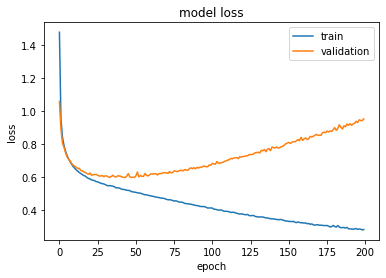

In [47]:
print(history_model_fc1.history.keys())

plt.plot(history_model_fc1.history['loss'])
plt.plot(history_model_fc1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [48]:
pred_model_fc1_yhot_test = model_fc1.predict(X_test)
pred_model_fc1_yhot_test_round = pred_model_fc1_yhot_test.round()
pred_yhot_test = np.argmax(pred_model_fc1_yhot_test_round, axis=1)
class_yhot_test = np.argmax(yhot_test, axis=1)

In [49]:
accuracy_score(class_yhot_test, pred_yhot_test)

0.7828625284708223

### (1) Window Method

In [52]:
def build_lstm1(feature_dim = 20):
    time_steps = 3
    

    x = Input(shape=(time_steps, feature_dim))
    h1 = LSTM(512, activation='relu')(x)
    r = Dense(1, activation='sigmoid')(h1)
    
    return Model(inputs=x, outputs=r)

In [56]:
model_1 = build_lstm1(20)
#optimizer = keras.optimizers.SGD(learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=1e-4)
model_1.compile(optimizer=optimizer, loss='mse')
model_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1091584   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 1,092,097
Trainable params: 1,092,097
Non-trainable params: 0
_________________________________________________________________


In [57]:
X_train.shape

(100042, 3, 20)

In [58]:
epochs = 200
batch_size = 512

history = model_1.fit(X_train, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test, y_test_std))

Train on 100042 samples, validate on 50022 samples
Epoch 1/200
100042/100042 [==============================] - 4s 40us/step - loss: 0.0193 - val_loss: 0.0044
Epoch 2/200
100042/100042 [==============================] - 4s 38us/step - loss: 0.0033 - val_loss: 0.0022
Epoch 3/200
100042/100042 [==============================] - 4s 38us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/200
100042/100042 [==============================] - 4s 39us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/200
100042/100042 [==============================] - 4s 39us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/200
100042/100042 [==============================] - 4s 39us/step - loss: 9.1631e-04 - val_loss: 8.0427e-04
Epoch 7/200
100042/100042 [==============================] - 4s 38us/step - loss: 8.8723e-04 - val_loss: 6.4473e-04
Epoch 8/200
100042/100042 [==============================] - 4s 38us/step - loss: 6.3362e-04 - val_loss: 6.2046e-04
Epoch 9/200
100042/100042 [==============================] - 

100042/100042 [==============================] - 4s 39us/step - loss: 1.1128e-04 - val_loss: 7.8987e-05
Epoch 72/200
100042/100042 [==============================] - 4s 39us/step - loss: 1.1050e-04 - val_loss: 8.2972e-05
Epoch 73/200
100042/100042 [==============================] - 4s 39us/step - loss: 1.4225e-04 - val_loss: 1.7384e-04
Epoch 74/200
100042/100042 [==============================] - 4s 39us/step - loss: 1.1134e-04 - val_loss: 1.3461e-04
Epoch 75/200
100042/100042 [==============================] - 4s 40us/step - loss: 1.0367e-04 - val_loss: 7.9106e-05
Epoch 76/200
100042/100042 [==============================] - 4s 40us/step - loss: 1.2824e-04 - val_loss: 1.0074e-04
Epoch 77/200
100042/100042 [==============================] - 4s 40us/step - loss: 1.0745e-04 - val_loss: 7.9840e-05
Epoch 78/200
100042/100042 [==============================] - 4s 39us/step - loss: 8.3485e-05 - val_loss: 7.9019e-05
Epoch 79/200
100042/100042 [==============================] - 4s 39us/step - 

Epoch 141/200
100042/100042 [==============================] - 4s 40us/step - loss: 5.4588e-05 - val_loss: 5.4560e-05
Epoch 142/200
100042/100042 [==============================] - 4s 39us/step - loss: 4.9441e-05 - val_loss: 6.0543e-05
Epoch 143/200
100042/100042 [==============================] - 4s 39us/step - loss: 5.1473e-05 - val_loss: 8.9513e-05
Epoch 144/200
100042/100042 [==============================] - 4s 40us/step - loss: 1.0227e-04 - val_loss: 7.5739e-04
Epoch 145/200
100042/100042 [==============================] - 4s 38us/step - loss: 8.1363e-05 - val_loss: 5.2866e-05
Epoch 146/200
100042/100042 [==============================] - 4s 39us/step - loss: 5.6641e-05 - val_loss: 5.4288e-05
Epoch 147/200
100042/100042 [==============================] - 4s 37us/step - loss: 5.2452e-05 - val_loss: 6.0337e-05
Epoch 148/200
100042/100042 [==============================] - 4s 39us/step - loss: 5.8755e-05 - val_loss: 5.7662e-05
Epoch 149/200
100042/100042 [===========================

In [59]:
pred_model_1_y_test_std = model_1.predict(X_val)
pred_model_1_y_test = pred_model_1_y_test_std*(ymax-ymin) + ymin

rmse_model_1 = np.sqrt(mean_squared_error(y_val, pred_model_1_y_test))
print("RMSE of model_1: ", rmse_model_1)
print("I.E. %.04f degree of mean error" % (rmse_model_1/math.pi*180))

RMSE of model_1:  0.01908025600644741
I.E. 1.0932 degree of mean error


In [60]:
import pickle

with open(join('checkpoints', '1-LSTM_X_105.pkl'), 'wb') as a_file:
    pickle.dump(model_1, a_file)

In [ ]:
with open(join('checkpoints', '1-LSTM_X_105.pkl'), 'rb') as a_file:
    model_1 = pickle.load(a_file)

### (2) Bidirectional LSTM

In [168]:
def build_lstm2(feature_dim = 20):
    time_steps = 3
    
    x = Input(shape=(time_steps, feature_dim))
    h1 = Bidirectional(LSTM(512, activation='relu'))(x)
    r = Dense(1, activation='sigmoid')(h1)
    
    return Model(inputs=x, outputs=r)

In [169]:
model_2 = build_lstm2()
optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=1e-4)
model_2.compile(optimizer=optimizer, loss='mse')
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              2183168   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 2,184,193
Trainable params: 2,184,193
Non-trainable params: 0
_________________________________________________________________


In [170]:
epochs = 200
batch_size = 512

history = model_2.fit(X_train, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test, y_test_std))


Train on 100042 samples, validate on 50022 samples
Epoch 1/200
100042/100042 [==============================] - 7s 67us/step - loss: 0.0176 - val_loss: 0.0057
Epoch 2/200
100042/100042 [==============================] - 6s 63us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 3/200
100042/100042 [==============================] - 6s 61us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 4/200
100042/100042 [==============================] - 6s 60us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/200
100042/100042 [==============================] - 6s 61us/step - loss: 8.7010e-04 - val_loss: 7.8846e-04
Epoch 6/200
100042/100042 [==============================] - 6s 61us/step - loss: 8.7040e-04 - val_loss: 6.9716e-04
Epoch 7/200
100042/100042 [==============================] - 6s 61us/step - loss: 7.5578e-04 - val_loss: 5.1394e-04
Epoch 8/200
100042/100042 [==============================] - 6s 61us/step - loss: 6.5832e-04 - val_loss: 0.0011
Epoch 9/200
100042/100042 [=============================

Epoch 139/200
100042/100042 [==============================] - 7s 69us/step - loss: 4.5580e-05 - val_loss: 4.7306e-05
Epoch 140/200
100042/100042 [==============================] - 7s 68us/step - loss: 4.1918e-05 - val_loss: 4.3654e-05
Epoch 141/200
100042/100042 [==============================] - 7s 68us/step - loss: 4.4821e-05 - val_loss: 4.7861e-05
Epoch 142/200
100042/100042 [==============================] - 7s 68us/step - loss: 5.8953e-05 - val_loss: 7.5132e-05
Epoch 143/200
100042/100042 [==============================] - 7s 67us/step - loss: 7.2003e-05 - val_loss: 5.2961e-05
Epoch 144/200
100042/100042 [==============================] - 7s 68us/step - loss: 4.6801e-05 - val_loss: 4.8505e-05
Epoch 145/200
100042/100042 [==============================] - 7s 68us/step - loss: 4.2117e-05 - val_loss: 5.0648e-05
Epoch 146/200
100042/100042 [==============================] - 7s 68us/step - loss: 4.6289e-05 - val_loss: 5.7890e-05
Epoch 147/200
100042/100042 [===========================

In [171]:
pred_model_2_y_test_std = model_2.predict(X_test)
pred_model_2_y_test = pred_model_2_y_test_std*(ymax-ymin) + ymin

rmse_model_2 = np.sqrt(mean_squared_error(y_test, pred_model_2_y_test))
print("RMSE of model_2: ", rmse_model_2)
print("I.E. %.04f degree of mean error" % (rmse_model_2/math.pi*180))

RMSE of model_2:  0.015097687813266916
I.E. 0.8650 degree of mean error


### (3) Stacked LSTM

In [61]:
def build_lstm3(feature_dim = 20):
    time_steps = 3
    

    # define model LSTM-only
    x = Input(shape=(time_steps, feature_dim))
    h1 = LSTM(128, activation='relu', return_sequences=True)(x)
    h2 = LSTM(64, activation='relu')(h1)
    #h2 = LSTM(16, activation='relu')(h1)
    #h3 = Dense(9, activation='relu')(h2)
    r = Dense(1, activation='sigmoid')(h2)
    
    return Model(inputs=x, outputs=r)

model_3 = build_lstm3(20)

# Customize LR & Optimizer
'''
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.96)
'''
#optimizer = keras.optimizers.SGD(learning_rate=0.001, nesterov=True)
optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=1e-4)
model_3.compile(optimizer=optimizer, loss='mse')
model_3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 125,761
Trainable params: 125,761
Non-trainable params: 0
_________________________________________________________________


In [62]:
epochs = 200
batch_size = 512

history = model_3.fit(X_train, y_train_std, batch_size=batch_size, epochs=epochs, \
                      verbose=1, validation_data=(X_val, y_val_std))

Train on 100042 samples, validate on 100043 samples
Epoch 1/200
100042/100042 [==============================] - 2s 24us/step - loss: 0.0201 - val_loss: 0.0039
Epoch 2/200
100042/100042 [==============================] - 2s 19us/step - loss: 0.0035 - val_loss: 0.0026
Epoch 3/200
100042/100042 [==============================] - 2s 18us/step - loss: 0.0022 - val_loss: 0.0027
Epoch 4/200
100042/100042 [==============================] - 2s 19us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 5/200
100042/100042 [==============================] - 2s 20us/step - loss: 0.0011 - val_loss: 9.9667e-04
Epoch 6/200
100042/100042 [==============================] - 2s 19us/step - loss: 0.0012 - val_loss: 8.1291e-04
Epoch 7/200
100042/100042 [==============================] - 2s 20us/step - loss: 9.9126e-04 - val_loss: 9.1096e-04
Epoch 8/200
100042/100042 [==============================] - 2s 19us/step - loss: 8.0932e-04 - val_loss: 8.3719e-04
Epoch 9/200
100042/100042 [==============================] -

Epoch 71/200
100042/100042 [==============================] - 2s 20us/step - loss: 9.5357e-05 - val_loss: 9.0931e-05
Epoch 72/200
100042/100042 [==============================] - 2s 21us/step - loss: 9.1121e-05 - val_loss: 8.1028e-05
Epoch 73/200
100042/100042 [==============================] - 2s 20us/step - loss: 1.1281e-04 - val_loss: 1.9590e-04
Epoch 74/200
100042/100042 [==============================] - 2s 20us/step - loss: 1.0091e-04 - val_loss: 9.1035e-05
Epoch 75/200
100042/100042 [==============================] - 3s 27us/step - loss: 8.8706e-05 - val_loss: 1.0042e-04
Epoch 76/200
100042/100042 [==============================] - 2s 22us/step - loss: 1.0142e-04 - val_loss: 2.6326e-04
Epoch 77/200
100042/100042 [==============================] - 3s 25us/step - loss: 1.1928e-04 - val_loss: 9.1200e-05
Epoch 78/200
100042/100042 [==============================] - 2s 21us/step - loss: 9.5144e-05 - val_loss: 8.4151e-05
Epoch 79/200
100042/100042 [==============================] - 2s

In [48]:
# Save/Load Model

#model_3.save(join("checkpoints", "model_3_stackedLSTM.h5"))
# OR
#model_3 = keras.models.load_model(join("checkpoints", "model_3_stackedLSTM.h5"))

dict_keys(['val_loss', 'loss'])


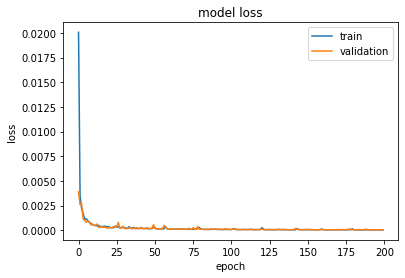

In [66]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [67]:
pred_model_3_y_test_std = model_3.predict(X_test)
pred_model_3_y_test = pred_model_3_y_test_std*(ymax-ymin) + ymin
pred_model_3_y_test.shape

(50022, 1)

In [68]:
rmse_lstm_3 = np.sqrt(mean_squared_error(y_test, pred_model_3_y_test))
print("RMSE of Stacked LSTM: ", rmse_lstm_3)
print("I.E. %.04f degree of mean error" % (rmse_lstm_3/math.pi*180))

RMSE of Stacked LSTM:  0.014476189773571978
I.E. 0.8294 degree of mean error


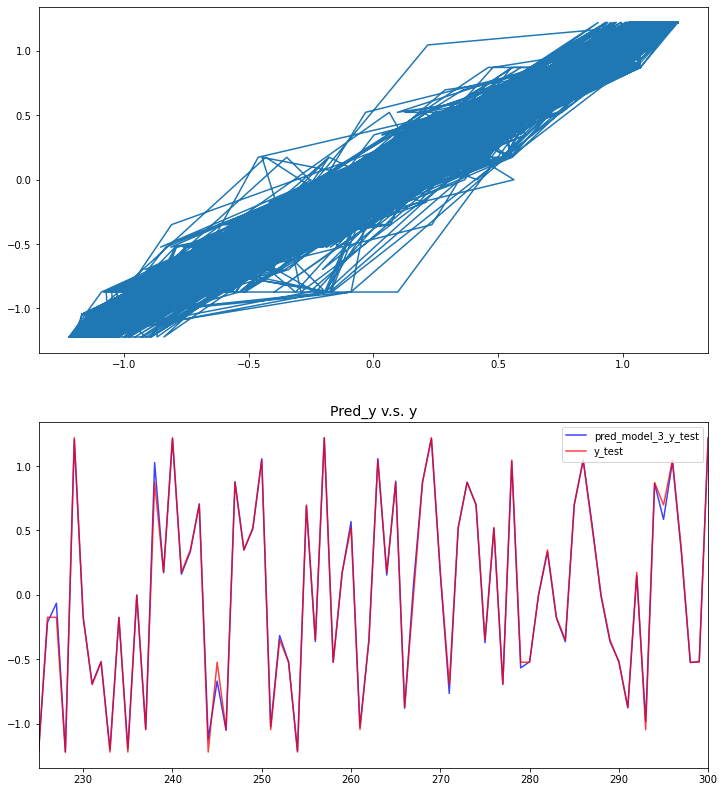

In [45]:
fig ,ax_lst = plt.subplots(2, 1,figsize=(12,14))
ax_lst[0].plot(pred_model_3_y_test, y_test)
ax_lst[1].plot([i for i in range(pred_model_3_y_test.shape[0])], list(pred_model_3_y_test), color='b', alpha=0.75, label='pred_model_3_y_test')
ax_lst[1].plot(y_test, color='red', alpha=0.75, label='y_test')
ax_lst[1].set_title(f"Pred_y v.s. y",fontsize=14)
ax_lst[1].grid(False)
ax_lst[1].legend(loc='upper right')
ax_lst[1].set_xlim([225, 300])
plt.show()

In [69]:
import pickle

# Save
with open(join('checkpoints', 'Stacked-LSTM_X_105.pkl'), 'wb') as a_file:
    pickle.dump(model_3, a_file)

In [ ]:
# Load
with open(join('checkpoints', 'Stacked-LSTM_X_105.pkl'), 'rb') as a_file:
    model_3 = pickle.load(a_file)

## LSTM-Autoencoder
liuzm-DNN-DOA

In [71]:
feature_dim = 12
SF = 15

aec_x = Input(shape=(feature_dim, ))
aec1 = Dense(10, activation='linear')(aec_x)

aec_out = []
for i in range(SF):
    aec_out.append(Dense(feature_dim, activation='linear')(aec1))

AEC = Model(inputs=aec_x, outputs=aec_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
AEC.compile(optimizer=optimizer, loss=['mse' for i in range(SF)])
AEC.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           130         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12)           132         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 12)           132         dense_1[0][0]                    
____________________________________________________________________________________________

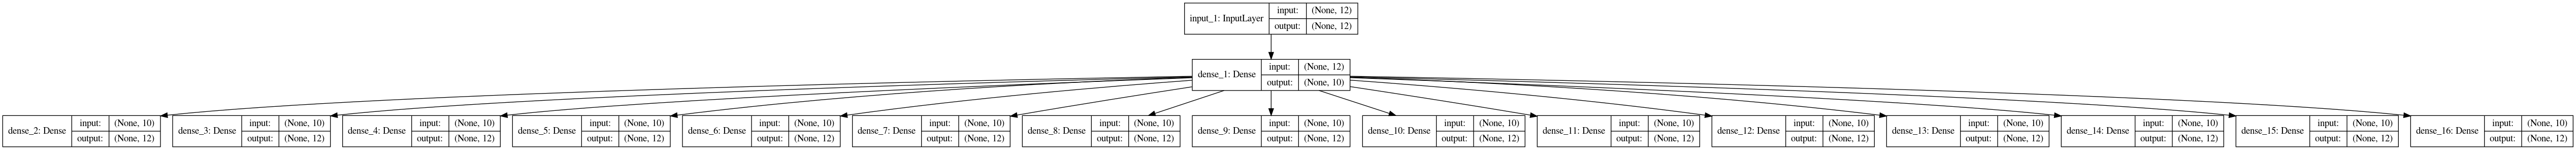

In [6]:
plot_model(
    AEC,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [101]:
AEC.output_shape

[(None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12),
 (None, 12)]

In [97]:
y_AEC_train_lst = []
for i in range(y_AEC_train.shape[2]):
    y_AEC_train_lst.append(y_AEC_train[:, :, i])
y_AEC_test_lst = []
for i in range(y_AEC_test.shape[2]):
    y_AEC_test_lst.append(y_AEC_test[:, :, i])
y_AEC_val_lst = []
for i in range(y_AEC_val.shape[2]):
    y_AEC_val_lst.append(y_AEC_val[:, :, i])

In [81]:
y_AEC_train[:, :, 0].shape

(125058, 12)

In [98]:
epochs = 30
batch_size = 128

history_aec = AEC.fit(X_train, y_AEC_train_lst, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_AEC_val_lst))

Train on 125058 samples, validate on 125058 samples
Epoch 1/30
125058/125058 [==============================] - 5s 36us/step - loss: 0.0107 - dense_2_loss: 6.1643e-04 - dense_3_loss: 6.2007e-04 - dense_4_loss: 7.7882e-04 - dense_5_loss: 6.0642e-04 - dense_6_loss: 8.0967e-04 - dense_7_loss: 7.5857e-04 - dense_8_loss: 8.2785e-04 - dense_9_loss: 5.7876e-04 - dense_10_loss: 6.3131e-04 - dense_11_loss: 5.0610e-04 - dense_12_loss: 5.9488e-04 - dense_13_loss: 6.7565e-04 - dense_14_loss: 8.8252e-04 - dense_15_loss: 0.0010 - dense_16_loss: 7.4294e-04 - val_loss: 0.0104 - val_dense_2_loss: 5.8783e-04 - val_dense_3_loss: 5.8497e-04 - val_dense_4_loss: 7.5871e-04 - val_dense_5_loss: 5.8752e-04 - val_dense_6_loss: 7.8412e-04 - val_dense_7_loss: 7.5117e-04 - val_dense_8_loss: 8.1642e-04 - val_dense_9_loss: 5.7724e-04 - val_dense_10_loss: 6.0758e-04 - val_dense_11_loss: 5.0472e-04 - val_dense_12_loss: 5.7534e-04 - val_dense_13_loss: 6.6706e-04 - val_dense_14_loss: 8.6794e-04 - val_dense_15_loss: 9.84

125058/125058 [==============================] - 5s 39us/step - loss: 0.0095 - dense_2_loss: 4.9493e-04 - dense_3_loss: 5.5508e-04 - dense_4_loss: 7.2575e-04 - dense_5_loss: 5.5180e-04 - dense_6_loss: 7.1766e-04 - dense_7_loss: 6.8931e-04 - dense_8_loss: 7.0878e-04 - dense_9_loss: 5.2253e-04 - dense_10_loss: 5.5587e-04 - dense_11_loss: 4.8869e-04 - dense_12_loss: 5.3398e-04 - dense_13_loss: 5.9866e-04 - dense_14_loss: 8.2318e-04 - dense_15_loss: 8.5125e-04 - dense_16_loss: 6.9565e-04 - val_loss: 0.0094 - val_dense_2_loss: 4.9011e-04 - val_dense_3_loss: 5.3853e-04 - val_dense_4_loss: 7.0871e-04 - val_dense_5_loss: 5.4656e-04 - val_dense_6_loss: 7.2426e-04 - val_dense_7_loss: 6.9499e-04 - val_dense_8_loss: 7.0929e-04 - val_dense_9_loss: 5.2213e-04 - val_dense_10_loss: 5.4448e-04 - val_dense_11_loss: 4.9011e-04 - val_dense_12_loss: 5.2714e-04 - val_dense_13_loss: 5.9490e-04 - val_dense_14_loss: 8.0804e-04 - val_dense_15_loss: 8.2869e-04 - val_dense_16_loss: 6.9696e-04
Epoch 18/30
125058/1

In [99]:
pred_y_AEC_test_lst = AEC.predict(X_test)

In [106]:
for i in range(15):
    print(pred_y_AEC_test_lst[i][0, :])

[ 2.8835842e-05  1.6408649e-03 -1.5224111e-03 -1.5567643e-04
 -1.3089292e-04 -1.7563585e-03 -1.3548508e-02  3.0837398e-02
 -3.1976584e-02 -1.8931227e-04  1.6038252e-02  3.0300539e-02]
[-5.5730314e-04  4.8524002e-05  2.2763369e-04  1.1975442e-03
  3.4488548e-05  3.7570775e-05  6.2760338e-03  3.5041552e-03
 -3.5911566e-03 -1.9688467e-03 -5.4474715e-03  2.9671257e-03]
[ 0.00074684  0.00111796 -0.00043414  0.00100173 -0.00111239 -0.00117958
  0.01463467  0.00234512 -0.01376821 -0.00142664 -0.02350983  0.00687418]
[-1.1172148e-03  6.2695448e-04  2.1102290e-04 -9.6820266e-05
  2.8263149e-04 -7.4107811e-04  8.0827676e-04 -3.3038240e-03
 -8.3865854e-04 -4.8879087e-03 -3.8015530e-03  1.6353279e-04]
[-0.00269637  0.00135573  0.00035555 -0.00073214  0.0010005  -0.0020338
  0.00246462 -0.00763517  0.01075351 -0.00962904 -0.00928399  0.00230799]
[-0.00195884  0.00184599  0.00052931  0.00014817  0.00376259 -0.00040718
  0.01217427 -0.01185872  0.02573572 -0.01921364  0.01783197 -0.02034738]
[-1.2484

In [107]:
for i in range(15):
    print(y_AEC_test_lst[i][0, :])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.00504908  0.01671184 -0.00666631  0.01020642  0.03090053 -0.02316523
  0.04148757  0.04935579 -0.07012966 -0.19205566 -0.13448215 -0.0489529 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


DeepAOANet

In [46]:
time_steps = 3
feature_dim = 20 #6

x0 = Input(shape=(time_steps, feature_dim))
l1 = LSTM(128, activation='relu', return_sequences=True)(x0)
l2 = LSTM(64, activation='relu', return_sequences=False)(l1)
h0 = RepeatVector(time_steps)(l2)
l3 = LSTM(64, activation='relu', return_sequences=True)(h0)
l4 = LSTM(128, activation='relu', return_sequences=True)(l3)
r0 = TimeDistributed(Dense(feature_dim))(l4)


LSTM_AE = Model(inputs=x0, outputs=r0)
LSTM_AE_optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=1e-3)
LSTM_AE.compile(optimizer=LSTM_AE_optimizer, loss='mse')
LSTM_AE.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 128)            98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 20)             2580

In [47]:
epochs = 200
batch_size = 512

history_lstm_ae = LSTM_AE.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, X_val))

Train on 100042 samples, validate on 100043 samples
Epoch 1/200
100042/100042 [==============================] - 4s 41us/step - loss: 0.0081 - val_loss: 3.7529e-04
Epoch 2/200
100042/100042 [==============================] - 3s 34us/step - loss: 2.8896e-04 - val_loss: 2.6762e-04
Epoch 3/200
100042/100042 [==============================] - 3s 34us/step - loss: 2.4117e-04 - val_loss: 2.3241e-04
Epoch 4/200
100042/100042 [==============================] - 3s 34us/step - loss: 2.2694e-04 - val_loss: 2.2732e-04
Epoch 5/200
100042/100042 [==============================] - 3s 33us/step - loss: 2.2001e-04 - val_loss: 2.1547e-04
Epoch 6/200
100042/100042 [==============================] - 3s 34us/step - loss: 2.0925e-04 - val_loss: 2.0090e-04
Epoch 7/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.9033e-04 - val_loss: 1.7783e-04
Epoch 8/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.6765e-04 - val_loss: 1.6096e-04
Epoch 9/200
100042/10004

Epoch 140/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.1191e-05 - val_loss: 1.1531e-05
Epoch 141/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.1171e-05 - val_loss: 1.1440e-05
Epoch 142/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.1137e-05 - val_loss: 1.1496e-05
Epoch 143/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.1115e-05 - val_loss: 1.1681e-05
Epoch 144/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.1068e-05 - val_loss: 1.1732e-05
Epoch 145/200
100042/100042 [==============================] - 3s 33us/step - loss: 1.1049e-05 - val_loss: 1.1297e-05
Epoch 146/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.0982e-05 - val_loss: 1.1318e-05
Epoch 147/200
100042/100042 [==============================] - 3s 34us/step - loss: 1.0948e-05 - val_loss: 1.1322e-05
Epoch 148/200
100042/100042 [===========================

In [298]:
pred_X_test_std = LSTM_AE.predict(X_test, verbose=0)
print('---Predicted---')
print(np.round(pred_X_test_std, 4))
print('---Actual---')
print(np.round(X_test_std, 4))

---Predicted---
[[[ 9.072e-01  3.800e-03  2.964e-01 ...  4.969e-01  7.278e-01 -1.200e-03]
  [ 9.000e-04  4.600e-03  2.839e-01 ...  8.226e-01  9.159e-01 -2.400e-03]
  [ 8.970e-01 -1.400e-03  3.003e-01 ...  5.127e-01  7.464e-01  1.700e-03]]

 [[ 4.700e-03  1.000e-04  3.721e-01 ...  7.531e-01  4.164e-01 -6.000e-04]
  [ 3.700e-03  3.000e-04  3.677e-01 ...  7.593e-01  4.215e-01  0.000e+00]
  [ 3.700e-03  7.000e-04  3.705e-01 ...  7.589e-01  4.195e-01 -1.000e-04]]

 [[ 8.979e-01  2.000e-04  3.081e-01 ...  4.996e-01  7.446e-01  3.000e-04]
  [ 9.035e-01  1.600e-03  3.091e-01 ...  5.062e-01  7.476e-01 -3.000e-04]
  [ 8.916e-01  6.000e-04  3.072e-01 ...  5.074e-01  7.446e-01 -5.000e-04]]

 ...

 [[ 8.959e-01  2.000e-04  3.090e-01 ...  5.023e-01  7.394e-01  2.000e-04]
  [ 9.135e-01  1.600e-03  3.060e-01 ...  5.047e-01  7.460e-01 -1.000e-04]
  [ 8.934e-01  5.000e-04  3.071e-01 ...  5.049e-01  7.456e-01 -1.000e-04]]

 [[ 8.956e-01  3.000e-04  3.115e-01 ...  5.012e-01  7.413e-01  3.000e-04]
  [ 9.06

In [48]:
encoder = Model(inputs=x0, outputs=l2)
encoder.compile(optimizer='adam', loss='mse')
encoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
Total params: 125,696
Trainable params: 125,696
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Predict both Train/Test data for further training the Regressor
pred_encoded_X_train_std = encoder.predict(X_train)
pred_encoded_X_test_std = encoder.predict(X_test)
pred_encoded_X_val_std = encoder.predict(X_val)
pred_encoded_X_test_std.shape

(50022, 64)

### Dense-regressor on Encoded R-features

In [55]:
def build_regressor(feature_dim = 64):
    
    
    x = Input(shape=(feature_dim,))
    h1 = Dense(256, activation='relu')(x)
    h2 = Dense(512, activation='relu')(h1)
    h3 = Dense(256, activation='relu')(h2)
    h4 = Dense(128, activation='relu')(h3)
    r = Dense(1, activation='sigmoid')(h4)
    
    return Model(inputs=x, outputs=r)

model_4 = build_regressor(64)
Regressor_optimizer = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-4)
model_4.compile(optimizer=Regressor_optimizer, loss='mse')
model_4.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_21 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 312,577
Trainable params: 312,577
Non-trainable params: 0
_____________________________________________________

In [56]:
epochs = 200
batch_size = 256

history_model_4 = model_4.fit(pred_encoded_X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(pred_encoded_X_val_std, y_val_std))

Train on 100042 samples, validate on 100043 samples
Epoch 1/200
100042/100042 [==============================] - 2s 17us/step - loss: 0.0256 - val_loss: 0.0126
Epoch 2/200
100042/100042 [==============================] - 1s 14us/step - loss: 0.0104 - val_loss: 0.0080
Epoch 3/200
100042/100042 [==============================] - 1s 13us/step - loss: 0.0063 - val_loss: 0.0052
Epoch 4/200
100042/100042 [==============================] - 1s 13us/step - loss: 0.0036 - val_loss: 0.0029
Epoch 5/200
100042/100042 [==============================] - 1s 13us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 6/200
100042/100042 [==============================] - 1s 12us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/200
100042/100042 [==============================] - 1s 13us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/200
100042/100042 [==============================] - 1s 14us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/200
100042/100042 [==============================] - 1s 12us/step - loss: 0.

Epoch 142/200
100042/100042 [==============================] - 1s 13us/step - loss: 4.0815e-04 - val_loss: 4.4086e-04
Epoch 143/200
100042/100042 [==============================] - 1s 14us/step - loss: 4.0947e-04 - val_loss: 3.9000e-04
Epoch 144/200
100042/100042 [==============================] - 1s 13us/step - loss: 4.0953e-04 - val_loss: 3.8882e-04
Epoch 145/200
100042/100042 [==============================] - 1s 14us/step - loss: 4.0960e-04 - val_loss: 3.8315e-04
Epoch 146/200
100042/100042 [==============================] - 1s 15us/step - loss: 4.0860e-04 - val_loss: 4.0486e-04
Epoch 147/200
100042/100042 [==============================] - 2s 17us/step - loss: 4.0796e-04 - val_loss: 4.1302e-04
Epoch 148/200
100042/100042 [==============================] - 2s 20us/step - loss: 3.9830e-04 - val_loss: 4.2687e-04
Epoch 149/200
100042/100042 [==============================] - 1s 15us/step - loss: 3.9985e-04 - val_loss: 4.0562e-04
Epoch 150/200
100042/100042 [===========================

In [57]:
pred_model_4_y_test_std = model_4.predict(pred_encoded_X_test_std)
pred_model_4_y_test = pred_model_4_y_test_std*(ymax-ymin) + ymin

rmse_model_4 = np.sqrt(mean_squared_error(y_test, pred_model_4_y_test))
print("RMSE of LSTM-AE + 4FC: ", rmse_model_4)
print("I.E. %.04f degree of mean error" % (rmse_model_4/math.pi*180))

RMSE of LSTM-AE + 4FC:  0.046166396617956115
I.E. 2.6451 degree of mean error


In [57]:
# Prepare unseen testing data
Xarr1.shape

(2230, 3, 6)

In [58]:
# Normalization
Xarr1_std = mmsc.transform(Xarr1.reshape(-1, Xarr1.shape[-1])).reshape(Xarr1.shape)
print(Xarr1_std.shape)

yarr1 = [item[0] for item in yarr1]
yarr1_std = (yarr1 - ymin)/(ymax-ymin)
print(yarr1_std.shape)

(2230, 3, 6)
(2230,)


Save and Load models

In [59]:
import pickle

encoder_fc_tuple = (encoder, model_4)

pkl_filename = "encoder_4fc_tuple_X_105.pkl"
with open(join('checkpoints', pkl_filename), 'wb') as a_file:
    pickle.dump(encoder_fc_tuple, a_file)

In [41]:
pkl_filename = "encoder_4fc_tuple_X_105.pkl"
with open(join('checkpoints', pkl_filename), 'rb') as a_file:
    encoder_cpy, model_4_cpy = pickle.load(a_file)
    
encoder_cpy.summary()
model_4_cpy.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
Total params: 125,696
Trainable params: 125,696
Non-trainable params: 0
_________________________________________________________________
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               16640     
___________________________________

In [43]:
# Predict output of model_4(encoder(X_train/test))
pred_encoded_LSTM_AE_4FC_std = encoder_cpy.predict(X_test)
pred_LSTM_AE_4FC_std = model_4_cpy.predict(pred_encoded_LSTM_AE_4FC_std)

In [45]:
pred_LSTM_AE_4FC = pred_LSTM_AE_4FC_std*(ymax-ymin) + ymin

rmse_LSTM_AE_4FC = np.sqrt(mean_squared_error(y_test, pred_LSTM_AE_4FC))
print("RMSE of (LSTM-AE + 4FC) upon unseen data X1: ", rmse_LSTM_AE_4FC)
print("I.E. %.04f degree of mean error" % (rmse_LSTM_AE_4FC/math.pi*180))

RMSE of (LSTM-AE + 4FC) upon unseen data X1:  0.046166396617956115
I.E. 2.6451 degree of mean error


### Build end-to-end Encoder+FC model

In [71]:
time_steps = 3
feature_dim = 20 #6

x0 = Input(shape=(time_steps, feature_dim))
l1 = LSTM(128, activation='relu', return_sequences=True)(x0)
l2 = LSTM(64, activation='relu', return_sequences=False)(l1)

# Build encoder_fc model
fc1 = Dense(256, activation='relu')(l2)
fc2 = Dense(512, activation='relu')(fc1)
fc3 = Dense(256, activation='relu')(fc2)
fc4 = Dense(128, activation='relu')(fc3)
fc_out = Dense(1, activation='sigmoid')(fc4)

model_encoder_fc = Model(inputs=x0, outputs=fc_out)

Encoder_fc_optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model_encoder_fc.compile(optimizer=Encoder_fc_optimizer, loss='mse')
model_encoder_fc.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               3289

In [72]:
epochs = 300
batch_size = 256

history_model_encoder_fc = model_encoder_fc.fit(X_train, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test, y_test_std))

Train on 100042 samples, validate on 50022 samples
Epoch 1/300
100042/100042 [==============================] - 4s 38us/step - loss: 0.0195 - val_loss: 0.0057
Epoch 2/300
100042/100042 [==============================] - 3s 30us/step - loss: 0.0039 - val_loss: 0.0028
Epoch 3/300
100042/100042 [==============================] - 3s 29us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 4/300
100042/100042 [==============================] - 3s 28us/step - loss: 0.0026 - val_loss: 0.0018
Epoch 5/300
100042/100042 [==============================] - 3s 29us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/300
100042/100042 [==============================] - 3s 30us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/300
100042/100042 [==============================] - 3s 30us/step - loss: 0.0010 - val_loss: 9.7114e-04
Epoch 8/300
100042/100042 [==============================] - 3s 29us/step - loss: 9.1219e-04 - val_loss: 7.6264e-04
Epoch 9/300
100042/100042 [==============================] - 3s 30us/step

Epoch 141/300
100042/100042 [==============================] - 3s 31us/step - loss: 9.2366e-05 - val_loss: 6.7365e-05
Epoch 142/300
100042/100042 [==============================] - 3s 34us/step - loss: 7.8539e-05 - val_loss: 5.4216e-05
Epoch 143/300
100042/100042 [==============================] - 3s 34us/step - loss: 6.4479e-05 - val_loss: 8.8078e-05
Epoch 144/300
100042/100042 [==============================] - 3s 29us/step - loss: 9.0775e-05 - val_loss: 4.4446e-05
Epoch 145/300
100042/100042 [==============================] - 3s 31us/step - loss: 4.5876e-05 - val_loss: 4.8055e-05
Epoch 146/300
100042/100042 [==============================] - 3s 31us/step - loss: 1.0731e-04 - val_loss: 5.7913e-05
Epoch 147/300
100042/100042 [==============================] - 3s 34us/step - loss: 6.1664e-05 - val_loss: 4.6796e-05
Epoch 148/300
100042/100042 [==============================] - 3s 30us/step - loss: 4.0659e-04 - val_loss: 3.3423e-04
Epoch 149/300
100042/100042 [===========================

100042/100042 [==============================] - 3s 31us/step - loss: 5.2450e-05 - val_loss: 1.7907e-04
Epoch 280/300
100042/100042 [==============================] - 3s 31us/step - loss: 4.2905e-05 - val_loss: 3.0435e-05
Epoch 281/300
100042/100042 [==============================] - 4s 37us/step - loss: 8.1357e-05 - val_loss: 0.0024
Epoch 282/300
100042/100042 [==============================] - 3s 32us/step - loss: 2.6261e-04 - val_loss: 4.7712e-05
Epoch 283/300
100042/100042 [==============================] - 3s 31us/step - loss: 3.8320e-05 - val_loss: 3.1296e-05
Epoch 284/300
100042/100042 [==============================] - 4s 41us/step - loss: 3.3381e-05 - val_loss: 2.7350e-05
Epoch 285/300
100042/100042 [==============================] - 3s 29us/step - loss: 1.2691e-04 - val_loss: 4.5898e-05
Epoch 286/300
100042/100042 [==============================] - 3s 30us/step - loss: 3.2214e-05 - val_loss: 5.7052e-05
Epoch 287/300
100042/100042 [==============================] - 3s 30us/ste

In [73]:
pred_model_encoder_fc_y_test_std = model_encoder_fc.predict(X_test)
pred_model_encoder_fc_y_test = pred_model_encoder_fc_y_test_std*(ymax-ymin) + ymin

rmse_model_encoder_fc = np.sqrt(mean_squared_error(y_test, pred_model_encoder_fc_y_test))
print("RMSE of ENCODER-FC: ", rmse_model_encoder_fc)
print("I.E. %.04f degree of mean error" % (rmse_model_encoder_fc/math.pi*180))

RMSE of ENCODER-FC:  0.013476036123474023
I.E. 0.7721 degree of mean error


In [157]:
# Try unseen data X1
pred_ENCODER_FC_E2E_std = model_encoder_fc.predict(Xarr1)
pred_ENCODER_FC_E2E = pred_ENCODER_FC_E2E_std*(ymax-ymin) + ymin

rmse_ENCODER_FC_E2E = np.sqrt(mean_squared_error(yarr1, pred_ENCODER_FC_E2E))
print("RMSE [Rad] of (end-to-end ENCODER+FC) upon unseen data X1: ", rmse_ENCODER_FC_E2E)
print("I.E. %.04f degree of mean error" % (rmse_ENCODER_FC_E2E/math.pi*180))

RMSE [Rad] of (end-to-end ENCODER+FC) upon unseen data X1:  0.7433023721801533
I.E. 42.5881 degree of mean error


In [74]:
import pickle
# Save
with open(join('checkpoints', 'LSTM-AE-4FC_X_105.pkl'), 'wb') as a_file:
    pickle.dump(model_encoder_fc, a_file)

In [ ]:
# Load
with open(join('checkpoints', 'LSTM-AE-4FC_X_105.pkl'), 'rb') as a_file:
    model_encoder_fc = pickle.load(a_file)

### SVR on Encoded R-features (Optional)

In [69]:
# SVR
svr_ae = SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.01)
svr_ae.fit(pred_encoded_X_train_std, y_train)
svr_ae.score(pred_encoded_X_test_std, y_test)

0.9426798652526259

In [75]:
'''
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
grid = GridSearchCV(svr_3,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)
grid.fit(pred_encoded_X_train_std, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
'''

"\nparams = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}\ngrid = GridSearchCV(svr_3,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)\ngrid.fit(pred_encoded_X_train_std, y_train)\nprint(grid.best_estimator_)\nprint(grid.best_score_)\n"

In [180]:
with open(join('checkpoints', 'svr_ae.pkl'), 'wb') as a_file:
    pickle.dump(svr_ae, a_file)

In [145]:
with open(join('checkpoints', 'svr_ae.pkl'), 'rb') as a_file:
    svr_ae = pickle.load(a_file)

In [70]:
pred_EncodeSVR_y_test = svr_ae.predict(pred_encoded_X_val_std)
rmse_svr_ae = np.sqrt(mean_squared_error(y_val, pred_EncodeSVR_y_test))
print("RMSE [Rad] for LSTM-AE + SVR:", rmse_svr_ae)
print("I.E. %.04f degree of mean error" % (rmse_svr_ae/math.pi*180))

RMSE [Rad] for LSTM-AE + SVR: 0.17454503691309395
I.E. 10.0007 degree of mean error


In [152]:
# Try unseen data X1
pred_SVR_AE = svr_ae.predict(pred_encoded_LSTM_AE_4FC_std)

rmse_SVR_AE = np.sqrt(mean_squared_error(yarr1, pred_SVR_AE))
print("RMSE [Rad] of (LSTM-AE + SVR) upon unseen data X1: ", rmse_SVR_AE)
print("I.E. %.04f degree of mean error" % (rmse_SVR_AE/math.pi*180))

RMSE [Rad] of (LSTM-AE + SVR) upon unseen data X1:  2.110344460674068
I.E. 120.9138 degree of mean error


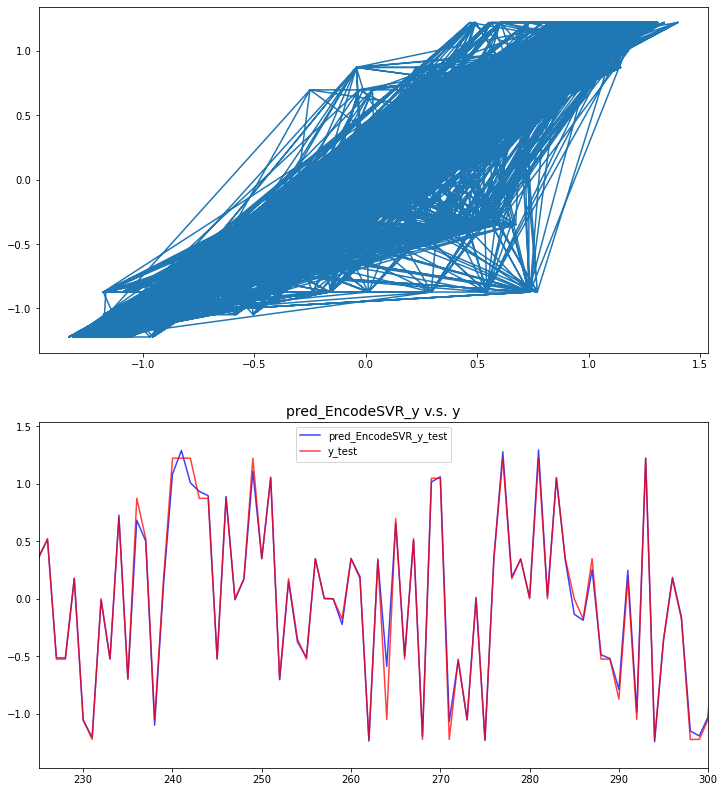

In [140]:
fig ,ax_lst = plt.subplots(2, 1,figsize=(12,14))
ax_lst[0].plot(pred_EncodeSVR_y_test, y_test)
ax_lst[1].plot([i for i in range(pred_EncodeSVR_y_test.shape[0])], list(pred_EncodeSVR_y_test), color='b', alpha=0.75, label='pred_EncodeSVR_y_test')
ax_lst[1].plot(y_test, color='red', alpha=0.75, label='y_test')
ax_lst[1].set_title(f"pred_EncodeSVR_y v.s. y",fontsize=14)
ax_lst[1].grid(False)
ax_lst[1].legend(loc='best')
ax_lst[1].set_xlim([225, 300])
plt.show()

### Visualize CDF

In [71]:
y_err_series = pd.Series(abs(y_val - pred_EncodeSVR_y_test) / math.pi*180)

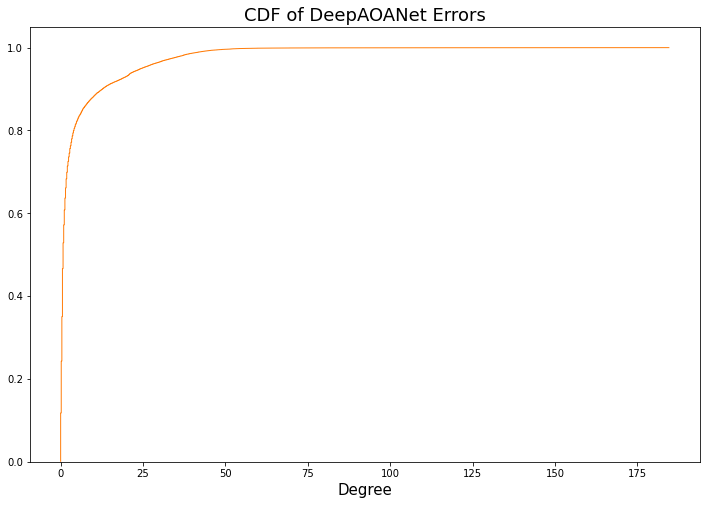

In [72]:
fig_hist, ax_hist = plt.subplots(1,1, figsize=(12,8))
n, bins, patches = ax_hist.hist(y_err_series, density=True, cumulative = True, histtype='step', bins=1000, color='tab:orange')
patches[0].set_xy(patches[0].get_xy()[:-1])
ax_hist.set_title("CDF of DeepAOANet Errors", fontsize=18)
ax_hist.set_xlabel("Degree", fontsize=15)
plt.show()

### Directly apply SVR on Rjk

In [75]:
# Xsingle equivalent to Xvec_clean
print(np.argwhere(np.isnan(yvec)), np.argwhere(np.isnan(yvec_clean)))

[[145087      0]
 [145088      0]
 [145089      0]
 [148528      0]
 [148529      0]
 [148530      0]
 [151969      0]
 [151970      0]
 [151971      0]
 [155410      0]
 [155411      0]
 [155412      0]
 [186379      0]
 [186380      0]
 [186381      0]
 [189820      0]
 [189821      0]
 [189822      0]
 [193261      0]
 [193262      0]
 [193263      0]
 [196702      0]
 [196703      0]
 [196704      0]] []


In [74]:
# repeat shuffle?
Xsingle = Xvec[~np.isnan(Xvec).any(axis=1)]
ysingle0 = yvec[~np.isnan(yvec).any(axis=1)]
ysingle = [item[0] for item in ysingle0]

In [76]:
yvec_clean.shape

(312645, 2)

In [77]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(Xvec_clean, yvec_clean[:,0], test_size=0.7, random_state=42)

In [84]:
svr_0 = SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.01)
svr_0.fit(X_train0, y_train0)
svr_0.score(X_test0, y_test0)

0.7462810025375146

In [181]:
# Save SVR
with open(join('checkpoints', 'svr_0.pkl'), 'wb') as a_file:
    pickle.dump(svr_0, a_file)

In [78]:
# Load SVR
with open(join('checkpoints', 'svr_0.pkl'), 'rb') as a_file:
    svr_0 = pickle.load(a_file)

In [79]:
pred_SVR0_y_test = svr_0.predict(X_test0)
rmse0 = np.sqrt(mean_squared_error(y_test0, pred_SVR0_y_test))
print("RMSE for SVR0:", rmse0)
print("I.E. %.04f degree of mean error" % (rmse0/math.pi*180))

RMSE for SVR0: 0.4976814884388284
I.E. 28.5150 degree of mean error


In [ ]:
# Unseen X1/Xphs1
pred_SVR0_Xvec1_test = svr_0.predict(Xvec1)
rmse_SVR0_Xvec1 = np.sqrt(mean_squared_error(yvec1[:, 0], pred_SVR0_Xvec1_test))
print("RMSE for SVR0 on unseen data:", rmse_SVR0_Xvec1)
print("I.E. %.04f degree of mean error" % (rmse_SVR0_Xvec1/math.pi*180))

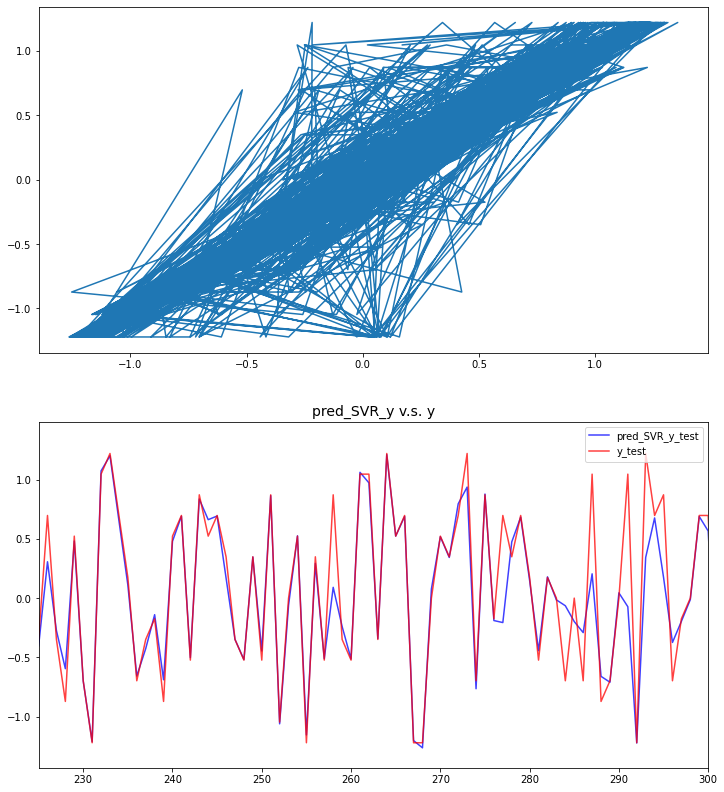

In [159]:
fig0 ,ax_lst0 = plt.subplots(2, 1,figsize=(12,14))
ax_lst0[0].plot(pred_SVR0_y_test[:2000], y_test0[:2000])
ax_lst0[1].plot([i for i in range(pred_SVR0_y_test.shape[0])], list(pred_SVR0_y_test), color='b', alpha=0.75, label='pred_SVR_y_test')
ax_lst0[1].plot(y_test0, color='red', alpha=0.75, label='y_test')
ax_lst0[1].set_title(f"pred_SVR_y v.s. y",fontsize=14)
ax_lst0[1].grid(False)
ax_lst0[1].legend(loc='best')
ax_lst0[1].set_xlim([225, 300])
plt.show()

# CDF

In [80]:
# Benchmark: MUSIC
y_err_music_series = pd.Series(abs(y_test[i] / math.pi*180 - y_test_music[i]) for i in range(len(y_test)))

In [81]:
# Benchmark: LSTM-AE + SVR
#y_err_lstm_ae_svr_series = pd.Series(abs(y_test - pred_EncodeSVR_y_test) / math.pi*180)

In [82]:
# Benchmark: SVR0
y_err_svr0_series = pd.Series(abs(y_test0 - pred_SVR0_y_test) / math.pi*180)

In [87]:
# Benchmark: LSTM-AE + 4FC
#y_err_lstm_ae_fc_series = pd.Series(abs(y_val - pred_model_4_y_test.ravel()) / math.pi*180)
#y_err_lstm_ae_fc_series = pd.Series(abs(y_test - pred_LSTM_AE_4FC.ravel()) / math.pi*180)
y_err_lstm_ae_fc_series = pd.Series(abs(y_test - pred_model_encoder_fc_y_test.ravel()) / math.pi*180)

In [85]:
# Benchmark: Stacked-LSTM
y_err_lstm_stacked_lstm_series = pd.Series(abs(y_test - pred_model_3_y_test.ravel()) / math.pi*180)

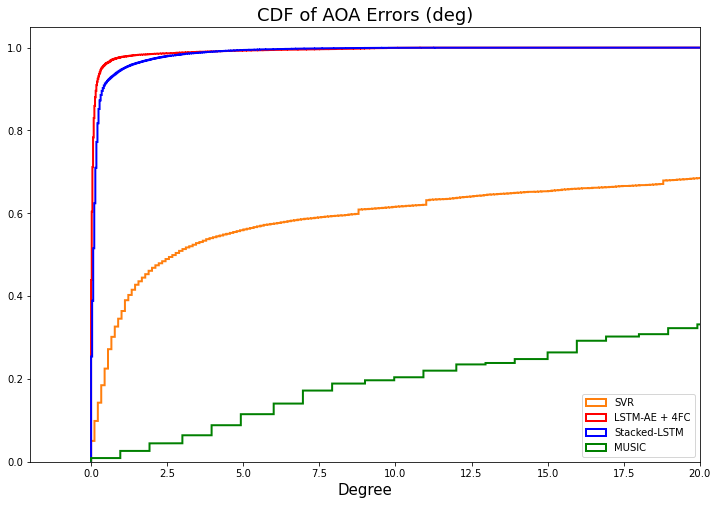

In [88]:
%matplotlib inline
fig_hist, ax_hist = plt.subplots(1,1, figsize=(12,8))
'''
n, bins, patches = ax_hist.hist(y_err_lstm_ae_svr_series, density=True, cumulative = True, histtype='step', \
                                bins=1000, color='tab:orange', linewidth=2, label='LSTM-AE + SVR')
patches[0].set_xy(patches[0].get_xy()[:-1])
'''
n, bins, patches = ax_hist.hist(y_err_svr0_series, density=True, cumulative = True, histtype='step', \
                                bins=1000, color='tab:orange', linewidth=2, label='SVR')
patches[0].set_xy(patches[0].get_xy()[:-1])
n2, bins2, patches2 = ax_hist.hist(y_err_lstm_ae_fc_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='red', linewidth=2, label='LSTM-AE + 4FC')
patches2[0].set_xy(patches2[0].get_xy()[:-1])
n3, bins3, patches3 = ax_hist.hist(y_err_lstm_stacked_lstm_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='b', linewidth=2, label='Stacked-LSTM')
patches3[0].set_xy(patches3[0].get_xy()[:-1])
n4, bins4, patches4 = ax_hist.hist(y_err_music_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='g', linewidth=2, label='MUSIC')
patches4[0].set_xy(patches4[0].get_xy()[:-1])

ax_hist.set_title("CDF of AOA Errors (deg)", fontsize=18)
ax_hist.set_xlabel("Degree", fontsize=15)
ax_hist.set_xlim(-2, 20)
ax_hist.legend(loc='lower right')

fig_hist.savefig(join('doc', 'CDF2.0_X_105.png'), facecolor="w", bbox_inches='tight')
plt.show()

# Validation
### (1) Unseen NLOS Data [-45, 0, 45]

In [2]:
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']
new_col = ['r12', 'r13', 'r14', 'r23', 'r24', 'r34']
# Show detection of LoRa beacon when Rjk is significant
field_thres = 1e-05

In [3]:
test_dict = {}
test_dir = join('data_1606', 'test')

for filename in os.listdir(test_dir):
    if filename.startswith("test_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        test_dict[- float(filename[6:-4])] = aoa_Rjk
    elif filename.startswith("test_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        test_dict[float(filename[5:-4])] = aoa_Rjk

In [6]:
test_sig = {}
test_sig_index = {}

for key in test_dict.keys():
    test_dict[key]['theta'] = key * math.pi / 180
    test_sig_index[key] = (test_dict[key][(abs(test_dict[key]['field.data2']) >= field_thres) \
                                                                                 & (abs(test_dict[key]['field.data3']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data4']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data5']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data6']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data7']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data12']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data13']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data14']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data15']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data22']) >= field_thres)\
                                                                                 & (abs(test_dict[key]['field.data23']) >= field_thres)].index)
    test_sig[key] = test_dict[key].iloc[test_sig_index[key], :]

X45 = pd.concat([test_sig[rad] for rad in test_dict.keys()], \
                 keys=[rad for rad in test_dict.keys()], names=['Series name', 'Row ID'])
X45['music'] = pd.Series([0] * len(X45.index))

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [8]:
print(X45.shape, len(X45))

(499, 22) 499


In [90]:
# CREATE: If using R_phase as input feature
Xphs_45, Xamp_45 = [], []
for item in [X45]:
    phs, amp = create_Xphs_Xamp(item)
    Xphs_45.append(phs)
    Xamp_45.append(amp)
    
Xphs_45[0]

r12       r13       r14       r23  r24       r34  \
Series name Row ID                                                     
-45.0       0       0.0 -0.584400 -2.562005 -1.698066  0.0 -2.149339   
            1       0.0 -0.435424 -2.517031 -1.727634  0.0 -1.703768   
            2       0.0 -1.983908 -2.656720 -1.502667  0.0  0.189015   
            3       0.0 -0.540016 -2.599287 -1.844297  0.0 -2.151937   
            15      0.0 -0.457718 -2.506565 -1.714339  0.0 -2.113907   
...                 ...       ...       ...       ...  ...       ...   
 45.0       1700    0.0 -0.680340 -2.799323 -0.808793  0.0 -2.554681   
            1701    0.0 -0.235561 -2.661797 -0.823952  0.0 -2.332732   
            1702    0.0  0.092232 -2.675180 -0.743071  0.0 -2.680688   
            1703    0.0 -0.340383 -2.803112 -0.903844  0.0 -2.574776   
            1704    0.0 -0.114608 -2.746498 -0.858374  0.0 -2.731961   

                       theta  music  
Series name Row ID                   
-45.0       0      -0.785398    NaN  
            1      -0.785398    NaN  
            2      -0.785398    NaN  
            3      -0.785398    NaN  
            15     -0.785398    NaN  
...                      ...    ...  
 45.0       1700    0.785398    NaN  
            1701    0.785398    NaN  
            1702    0.785398    NaN  
            1703    0.785398    NaN  
            1704    0.785398    NaN  

[3111 rows x 8 columns]

In [22]:
type(X45)

pandas.core.frame.DataFrame

In [15]:
# SPLIT
Xtest_arr, ytest_lst2, Xtest_vec, ytest_vec = Split_TimeSeries3(X45, aoa_gt_series=range(-45, 90, 45), \
                                                                   feature_space=20)
    
Xtest_arr.shape

(317, 3, 20)

In [16]:
ytest_vec.shape

(499, 2)

In [19]:
# SHUFFLE
X_train_null, X_test2, y_train_null, y_test2 = train_test_split(Xtest_arr, ytest_lst2, test_size=0.99, random_state=42)

In [20]:
print(X_test2.shape, len(y_test2))

(314, 3, 20) 314


In [38]:
# Normalization
#X_test2_std = mmsc.transform(X_test2.reshape(-1, X_test2.shape[-1])).reshape(X_test2.shape)

y_test2_lst = [item[0] for item in y_test2]
y_test2_lst_std = (y_test2_lst - ymin)/(ymax-ymin)

EVAL

In [99]:
# Stacked LSTM
pred_X_test2_std = model_3.predict(X_test2_std)
pred_X_test2 = pred_X_test2_std*(ymax - ymin) + ymin

pred_X_test2_std.shape

(2655, 1)

In [100]:
rmse_lstm_model_3_test2 = np.sqrt(mean_squared_error(y_test2_lst, pred_X_test2_std))
print("RMSE of Stacked LSTM: ", rmse_lstm_model_3_test2)
print("I.E. %.04f degree of mean error" % (rmse_lstm_model_3_test2/math.pi*180))

RMSE of Stacked LSTM:  0.6765697700547708
I.E. 38.7646 degree of mean error


In [101]:
# Encoder-SVR
pred_EncoderSVR_ytest_lst = svr_ae.predict(encoder.predict(X_test2_std))

rmse_EncoderSVR = np.sqrt(mean_squared_error(y_test2_lst, pred_EncoderSVR_ytest_lst))
print("RMSE of LSTM-Encoder + SVR: ", rmse_EncoderSVR)
print("I.E. %.04f degree of mean error" % (rmse_EncoderSVR/math.pi*180))

NameError: name 'svr_ae' is not defined

In [48]:
# Encoder-FC
pred_EncoderFC_ytest_lst = model_4_cpy.predict(encoder_cpy.predict(X_test2))

rmse_EncoderFC = np.sqrt(mean_squared_error(y_test2_lst, pred_EncoderFC_ytest_lst))
print("RMSE of LSTM-Encoder + FC: ", rmse_EncoderFC)
print("I.E. %.04f degree of mean error" % (rmse_EncoderFC/math.pi*180))

RMSE of LSTM-Encoder + FC:  1.2451705685713792
I.E. 71.3430 degree of mean error


In [108]:
# DirectSVR
#X_train_null, X_test2vec, y_train_null, y_test2vec = train_test_split(Xtest_vec, ytest_vec, test_size=0.9, random_state=42)
pred_SVR_0_X_test2 = svr_0.predict(X_test2[:, 0, :])
rmse_svronly2 = np.sqrt(mean_squared_error(y_test2_lst, pred_SVR_0_X_test2))
print("RMSE for SVR-Only:", rmse_svronly2)
print("I.E. %.04f degree of mean error" % (rmse_svronly2/math.pi*180))

RMSE for SVR-Only: 1.0544157098489537
I.E. 60.4136 degree of mean error


### (2) Test with SEEN LOS data [-45, -25, 25, 45]

In [10]:
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']

# Show detection of LoRa beacon when Rjk is significant
field_thres = 1e-05

# List of data.fields used in filtering
fields_filter_lst = ['field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data22', 'field.data23']

In [26]:
ymax = 1.2217304763960306
ymin =  -1.2217304763960306

In [38]:
def load_raw(test_dir = 'testLOS', field_thres=field_thres):
    
    aoa_dict = {}
    
    for filename in os.listdir(test_dir):
        if filename.startswith("deg_m") and filename.endswith(".csv"):
            aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[- float(filename[-6:-4])] = aoa_Rjk
        elif filename.startswith("deg_") and filename.endswith(".csv"):
            aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[float(filename[-6:-4])] = aoa_Rjk
            
    #Degree to Radian
    for key in aoa_dict.keys():
        aoa_dict[key]['theta'] = key * math.pi / 180
    
    # Differentiate R of LoRa signal or noise
    aoa_sig, aoa_noi = {}, {}
    sig_index_lst = {}

    for key in aoa_dict.keys():
        filtered_indexed = aoa_dict[key][(abs(aoa_dict[key]['field.data2']) >= field_thres) \
                                                                                 & (abs(aoa_dict[key]['field.data3']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data4']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data5']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data6']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data7']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data12']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data13']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data14']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data15']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data22']) >= field_thres)\
                                                                                 & (abs(aoa_dict[key]['field.data23']) >= field_thres)].index
        
        aoa_noi[key] = aoa_dict[key].drop(filtered_indexed)
        aoa_sig[key] = aoa_dict[key].iloc[filtered_indexed]
        sig_index_lst[key] = (filtered_indexed)
    
    # Concat dict of raw data into a DataFrame
    X = pd.concat([aoa_sig[rad] for rad in aoa_sig.keys()], \
                     keys=[rad for rad in aoa_sig.keys()], names=['Series name', 'Row ID'])
    X['music'] = pd.Series([0] * len(X.index))
    
    return X

In [39]:
X_test_LOS = load_raw()

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
# SPLIT
aoa_gt_lst = [-45, -25, 25, 45]

Xtest_arr, ytest_lst2, Xtest_vec, ytest_vec = Split_TimeSeries3(X_test_LOS, aoa_gt_series=aoa_gt_lst, \
                                                                   feature_space=20)

Xtest_arr.shape

(235, 3, 20)

In [42]:
# SHUFFLE
X_train_null, X_test, y_train_null, y_test = train_test_split(Xtest_arr, ytest_lst2, test_size=0.99, random_state=42)

In [48]:
X_test.shape

(233, 3, 20)

In [50]:
# Prepare
y_test_np = np.array([item[0] for item in y_test])
y_test_std = (y_test_np - ymin)/(ymax-ymin)

y_test_std.shape

(233,)

Evaluation

In [51]:
import pickle
# Load
with open(join('checkpoints', 'LSTM-AE-4FC_X_105.pkl'), 'rb') as a_file:
    model_encoder_fc = pickle.load(a_file)
model_encoder_fc.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               328

In [53]:
pred_X_test_std = model_encoder_fc.predict(X_test)
pred_X_test = pred_X_test_std*(ymax - ymin) + ymin

In [54]:
rmse_EncoderFC_on_testLOS = np.sqrt(mean_squared_error(y_test_np, pred_X_test))
print("RMSE of LSTM-Encoder + FC: ", rmse_EncoderFC_on_testLOS)
print("I.E. %.04f degree of mean error" % (rmse_EncoderFC_on_testLOS/math.pi*180))

RMSE of LSTM-Encoder + FC:  0.6839860370804993
I.E. 39.1895 degree of mean error


### (3) Test with SEEN Corridor data [-45, -25, 25, 45]

In [55]:
X_test_Cor = load_raw(test_dir = 'testCorridor')

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
# SPLIT
aoa_gt_lst = [-45, -25, 25, 45]
Xtest_arr, ytest_lst2, Xtest_vec, ytest_vec = Split_TimeSeries3(X_test_Cor, aoa_gt_series=aoa_gt_lst, \
                                                                   feature_space=20)

# SHUFFLE
X_train_null, X_test, y_train_null, y_test = train_test_split(Xtest_arr, ytest_lst2, \
                                                              test_size=0.99, random_state=42)

# Prepare
y_test_np = np.array([item[0] for item in y_test])
y_test_std = (y_test_np - ymin)/(ymax-ymin)

print(X_test.shape, y_test_np.shape)

(230, 3, 20) (230,)


In [57]:
import pickle
# Load
with open(join('checkpoints', 'LSTM-AE-4FC_X_105.pkl'), 'rb') as a_file:
    model_encoder_fc = pickle.load(a_file)
model_encoder_fc.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               3289

In [58]:
pred_X_test_std = model_encoder_fc.predict(X_test)
pred_X_test = pred_X_test_std*(ymax - ymin) + ymin

rmse_EncoderFC_on_testCor = np.sqrt(mean_squared_error(y_test_np, pred_X_test))
print("RMSE of LSTM-Encoder + FC: ", rmse_EncoderFC_on_testCor)
print("I.E. %.04f degree of mean error" % (rmse_EncoderFC_on_testCor/math.pi*180))

RMSE of LSTM-Encoder + FC:  0.993562806180296
I.E. 56.9270 degree of mean error
